In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip # Example COCO download
!unzip train2017.zip # Unzip the downloaded file

## create subset of 8k images


In [ ]:
import os

# Define base directory relative to the notebook location (which is vjti_solution)
# This assumes your 'src' folder is directly inside 'vjti_solution'
base_dir = 'src'

# Construct paths using os.path.join for better portability
image_dir = os.path.join(base_dir, 'train_subset')
subset_annotation_file = os.path.join(base_dir, 'subset_train_annotations.json')
output_dir = os.path.join(base_dir, 'masks_2')


train_image_dir = os.path.join(base_dir, '/train2017_data/train2017')
train_subset_dir = os.path.join(base_dir, 'train_subset')
annotation_file = os.path.join(base_dir, 'annotations/instances_train2017.json')


print(f"Current Working Directory: {os.getcwd()}") 
print(f"Image Directory: {image_dir}")
print(f"Annotation File: {annotation_file}")
print(f"Output Directory: {output_dir}")

In [ ]:
import os
import random
import shutil
import json

num_images_to_select = 8000

# Create the subset directory
os.makedirs(train_subset_dir, exist_ok=True)

# Get a list of image files
image_files = [f for f in os.listdir(train_image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Randomly select 8000 images
selected_images = random.sample(image_files, min(num_images_to_select, len(image_files)))

# Set the random seed
random_seed = 42 
random.seed(random_seed)

# Copy the selected images to the subset directory
for image_file in selected_images:
    src_path = os.path.join(train_image_dir, image_file)
    dst_path = os.path.join(train_subset_dir, image_file)
    shutil.copy(src_path, dst_path)

print(f"Copied {len(selected_images)} images to {train_subset_dir}")

# Process the annotation file.
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

image_id_to_filename = {img['id']: img['file_name'] for img in annotations['images']}
filename_to_image_id = {v: k for k, v in image_id_to_filename.items()}

subset_image_ids = [filename_to_image_id[f] for f in selected_images]

# Filter the annotations.
subset_images = [img for img in annotations['images'] if img['id'] in subset_image_ids]
subset_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] in subset_image_ids]

# Create a new annotation file.
subset_annotation_data = {'images': subset_images, 'annotations': subset_annotations}

with open(subset_annotation_file, 'w') as f:
    json.dump(subset_annotation_data, f)

print("Created subset train annotation file.")

Copied 8000 images to /home/csb/Neeraj/vjti_solution/src/train_subset
Created subset train annotation file.


#### get all the annotations

In [2]:
import json

#annotation_file = '/src/annotations/instances_train2017.json'  # Replace with your actual path

try:
    with open(annotation_file, 'r') as f:
        data = json.load(f)

    categories = data.get('categories', [])

    if not categories:
        print("No category information found in the annotation file.")
    else:
        print("Category Mapping:")
        for category in categories:
            print(f"  ID: {category['id']}, Name: {category['name']}")

except FileNotFoundError:
    print(f"Error: File '{annotation_file}' not found.")
except json.JSONDecodeError:
    print(f"Error: File '{annotation_file}' is not a valid JSON file.")
except KeyError as e:
    print(f"Error: Key '{e}' not found in the JSON file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Category Mapping:
  ID: 1, Name: person
  ID: 2, Name: bicycle
  ID: 3, Name: car
  ID: 4, Name: motorcycle
  ID: 5, Name: airplane
  ID: 6, Name: bus
  ID: 7, Name: train
  ID: 8, Name: truck
  ID: 9, Name: boat
  ID: 10, Name: traffic light
  ID: 11, Name: fire hydrant
  ID: 13, Name: stop sign
  ID: 14, Name: parking meter
  ID: 15, Name: bench
  ID: 16, Name: bird
  ID: 17, Name: cat
  ID: 18, Name: dog
  ID: 19, Name: horse
  ID: 20, Name: sheep
  ID: 21, Name: cow
  ID: 22, Name: elephant
  ID: 23, Name: bear
  ID: 24, Name: zebra
  ID: 25, Name: giraffe
  ID: 27, Name: backpack
  ID: 28, Name: umbrella
  ID: 31, Name: handbag
  ID: 32, Name: tie
  ID: 33, Name: suitcase
  ID: 34, Name: frisbee
  ID: 35, Name: skis
  ID: 36, Name: snowboard
  ID: 37, Name: sports ball
  ID: 38, Name: kite
  ID: 39, Name: baseball bat
  ID: 40, Name: baseball glove
  ID: 41, Name: skateboard
  ID: 42, Name: surfboard
  ID: 43, Name: tennis racket
  ID: 44, Name: bottle
  ID: 46, Name: wine glass
 

#### ## Creating mask: storing category_id along with image name to clearly see which category_id it consists of

In [ ]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm
import matplotlib.pyplot as plt

def create_segmentation_masks(image_dir, annotation_file, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    with open(annotation_file, 'r') as f:
        annotations = json.load(f)

    image_annotations = {}
    for ann in annotations['annotations']:
        image_id = ann['image_id']
        if image_id not in image_annotations:
            image_annotations[image_id] = []
        image_annotations[image_id].append(ann)

    image_id_to_filename = {img['id']: img['file_name'] for img in annotations['images']}

    for image_id, anns in tqdm(image_annotations.items(), desc="Processing Images"):
        filename = image_id_to_filename[image_id]
        image_path = os.path.join(image_dir, filename)

        try:
            image = Image.open(image_path).convert('RGB')
            width, height = image.size

            mask = np.zeros((height, width), dtype=np.uint8)
            mask_image = Image.new('L', (width, height), 0)
            draw = ImageDraw.Draw(mask_image)

            present_category_ids = sorted(list(set()))  # Sorted list for consistent naming

            for ann in anns:
                segmentation = ann['segmentation']
                category_id = ann['category_id']
                present_category_ids.append(category_id)  # Add category_id to the list

                if isinstance(segmentation, list):  # Polygon segmentation
                    for polygon in segmentation:
                        polygon_points = [(polygon[i], polygon[i + 1]) for i in range(0, len(polygon), 2)]
                        draw.polygon(polygon_points, fill=int(category_id * 100))
                        mask = np.maximum(mask, np.array(mask_image))
                        mask_image = Image.new('L', (width, height), 0)

            mask_image = Image.fromarray(mask)

            # Create the category ID string for the filename
            category_id_str = '_'.join(map(str, sorted(list(set(present_category_ids)))))  # Unique sorted IDs

            mask_filename = f"{os.path.splitext(filename)[0]}_mask_cats_{category_id_str}.png"
            mask_path = os.path.join(output_dir, mask_filename)
            mask_image.save(mask_path)

            print(f"Mask saved to {mask_path}")

        except FileNotFoundError:
            print(f"Error: Image not found: {image_path}")
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

# Example usage (replace with your actual paths):


create_segmentation_masks(image_dir, annotation_file, output_dir)

Processing Images:   0%|          | 35/7950 [00:00<00:46, 169.14it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000013882_mask_cats_18_70.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000390348_mask_cats_1_4_18_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000426342_mask_cats_1_18.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000278435_mask_cats_1_4_18_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000151988_mask_cats_1_15_18_27_44_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000070815_mask_cats_1_2_8_18.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000020671_mask_cats_1_3_18_44_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000049097_mask_cats_1_2_18_31_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000386968_mask_cats_1_2_18_31_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000102735_mask_cats_3_4_6_8_18.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/mask

Processing Images:   1%|          | 71/7950 [00:00<00:45, 173.30it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000129520_mask_cats_1_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000050411_mask_cats_1_3_8_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000161079_mask_cats_1_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000185327_mask_cats_1_3_6_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000019157_mask_cats_1_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000075216_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000149912_mask_cats_1_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000554466_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000092257_mask_cats_1_44_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000399851_mask_cats_44_49_50_51_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000105177_mask_cats_44_49_51_5

Processing Images:   1%|          | 89/7950 [00:00<00:45, 173.21it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000186165_mask_cats_44_51_62_67_79_81_82_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000567220_mask_cats_44_51_70.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000517018_mask_cats_44_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000162249_mask_cats_44_47_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000069750_mask_cats_44_50_51.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000412151_mask_cats_1_2_44_77_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000096107_mask_cats_44_47_50_51_62_64_67_79_80_81_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000306313_mask_cats_44_79_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000060203_mask_cats_44_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000027517_mask_cats_1_44_77_84.png
Mask saved to /home/csb/Neer

Processing Images:   2%|▏         | 124/7950 [00:00<00:46, 167.54it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000563542_mask_cats_1_3_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000556345_mask_cats_3_6_8_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000150284_mask_cats_1_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000206176_mask_cats_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000327314_mask_cats_1_4_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000198972_mask_cats_1_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000046571_mask_cats_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000071384_mask_cats_1_3_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000455261_mask_cats_1_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000326368_mask_cats_1_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000147068_mask_cats_1_4_28_31.png
Mask saved to /hom

Processing Images:   2%|▏         | 162/7950 [00:00<00:43, 179.13it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000045746_mask_cats_50_51_53_55_62_67_78_79_81_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000050753_mask_cats_65_72_78_79_80_81_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000205577_mask_cats_44_78_81_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000579226_mask_cats_1_84_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000133195_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000305472_mask_cats_16_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000021198_mask_cats_1_62_67_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000414711_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000471578_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000547106_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000

Processing Images:   3%|▎         | 200/7950 [00:01<00:42, 181.11it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000024386_mask_cats_1_70_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000262514_mask_cats_1_47_70_79_81_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000517793_mask_cats_1_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000065057_mask_cats_1_37.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000275015_mask_cats_1_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000149571_mask_cats_1_27_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000244151_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000578813_mask_cats_1_27_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000060623_mask_cats_1_46_50_51_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000426754_mask_cats_1_27_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000176275_mask_ca

Processing Images:   3%|▎         | 242/7950 [00:01<00:39, 193.95it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000050443_mask_cats_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000436520_mask_cats_70.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000260107_mask_cats_70.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000116424_mask_cats_70.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000433625_mask_cats_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000334161_mask_cats_44_70_81_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000219657_mask_cats_70.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000050350_mask_cats_51_70_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000196168_mask_cats_70_81_89.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000549817_mask_cats_70.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000571596_mask_cats_70_81.png
Mask saved to

Processing Images:   4%|▎         | 285/7950 [00:01<00:38, 200.79it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000545597_mask_cats_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000430420_mask_cats_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000366867_mask_cats_70_81_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000214664_mask_cats_47_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000543961_mask_cats_47_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000543178_mask_cats_79_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000275279_mask_cats_81_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000166532_mask_cats_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000341700_mask_cats_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000097017_mask_cats_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000269287_mask_cats_44_81_86.png
Mask saved to

Processing Images:   4%|▍         | 326/7950 [00:01<00:41, 182.01it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000348991_mask_cats_1_15_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000501788_mask_cats_17.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000219567_mask_cats_17_70.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000500859_mask_cats_15_17.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000432317_mask_cats_1_6_10_19_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000416960_mask_cats_19_20_21_61.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000027438_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000335631_mask_cats_1_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000354533_mask_cats_1_4_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000489248_mask_cats_1_15_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000330676_mask_cats_8_20.png


Processing Images:   5%|▍         | 363/7950 [00:02<00:45, 165.39it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000331686_mask_cats_1_3_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000219928_mask_cats_1_3_4_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000346716_mask_cats_1_3_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000336384_mask_cats_3_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000432333_mask_cats_1_3_6_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000362714_mask_cats_1_2_3_6_8_10_31_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000008181_mask_cats_3_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000476005_mask_cats_3_6_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000496680_mask_cats_1_3_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000579036_mask_cats_1_2_3_6_8_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000279850_mask_cats

Processing Images:   5%|▍         | 381/7950 [00:02<00:44, 168.67it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000462026_mask_cats_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000223930_mask_cats_1_2_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000512394_mask_cats_4_47_62_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000184531_mask_cats_1_3_4_8_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000061862_mask_cats_1_2_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000019443_mask_cats_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000394773_mask_cats_4_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000381599_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000386585_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000309836_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000008005_mask_cats_3_5_8.png
Mask saved to /home/c

Processing Images:   5%|▌         | 419/7950 [00:02<00:42, 176.60it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000259421_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000061259_mask_cats_5_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000083235_mask_cats_1_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000056736_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000263758_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000331405_mask_cats_5_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000295242_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000180411_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000533805_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000271266_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000237735_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src

Processing Images:   6%|▌         | 454/7950 [00:02<00:46, 161.62it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000089500_mask_cats_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000158277_mask_cats_9_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000284152_mask_cats_1_9_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000283438_mask_cats_1_62_72.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000541924_mask_cats_1_10_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000053580_mask_cats_1_6_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000495519_mask_cats_1_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000099081_mask_cats_1_7_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000268469_mask_cats_1_2_31_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000339022_mask_cats_1_4_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000285607_mask_cats_5.png
Mask saved

Processing Images:   6%|▌         | 492/7950 [00:02<00:43, 172.79it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000477846_mask_cats_3_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000480416_mask_cats_1_3_11_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000334276_mask_cats_1_3_8_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000558992_mask_cats_1_3_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000113333_mask_cats_1_3_8_10_11.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000308388_mask_cats_1_3_10_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000400189_mask_cats_1_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000000985_mask_cats_1_6_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000331642_mask_cats_1_3_6_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000217883_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000533721_mask_cats_44_47

Processing Images:   7%|▋         | 531/7950 [00:03<00:42, 173.61it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000013159_mask_cats_11.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000247609_mask_cats_11_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000025809_mask_cats_11.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000303197_mask_cats_11.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000094951_mask_cats_1_3_6_11_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000492163_mask_cats_11.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000203483_mask_cats_7_14.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000499268_mask_cats_1_15_31_44_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000576607_mask_cats_1_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000569314_mask_cats_1_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000337143_mask_cats_1_25.png
Mask saved t

Processing Images:   7%|▋         | 567/7950 [00:03<00:43, 168.97it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000397109_mask_cats_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000435751_mask_cats_9_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000084389_mask_cats_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000320893_mask_cats_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000149890_mask_cats_24_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000423723_mask_cats_24_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000505538_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000291330_mask_cats_16_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000032688_mask_cats_9_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000547858_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000276066_mask_cats_25.png
Mask saved to /home/csb/Neeraj

Processing Images:   8%|▊         | 604/7950 [00:03<00:41, 175.75it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000368291_mask_cats_50_51_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000185901_mask_cats_51_55.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000272694_mask_cats_47_52_61_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000029833_mask_cats_1_27_52.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000165818_mask_cats_51_52_67_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000380427_mask_cats_70.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000439398_mask_cats_70.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000257629_mask_cats_1_3_15_73_76_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000171349_mask_cats_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000541086_mask_cats_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000567609_mask_cats_16

Processing Images:   8%|▊         | 643/7950 [00:03<00:39, 182.96it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000498400_mask_cats_1_3_4_8_21_52_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000315863_mask_cats_1_7_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000494870_mask_cats_17_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000153832_mask_cats_7_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000002988_mask_cats_17_62_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000475893_mask_cats_3_8_14_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000382670_mask_cats_1_2_9_21_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000157261_mask_cats_7_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000408789_mask_cats_1_32_72.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000266250_mask_cats_1_17_63_72_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/0000000781

Processing Images:   9%|▊         | 684/7950 [00:03<00:37, 191.70it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000220716_mask_cats_9_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000346067_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000297419_mask_cats_16_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000478518_mask_cats_1_16_47.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000036414_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000481628_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000183114_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000037705_mask_cats_16_53.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000108982_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000176527_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000269918_mask_cats_1_17_62_63_84.png
Mask saved to /h

Processing Images:   9%|▉         | 723/7950 [00:04<00:40, 179.46it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000385540_mask_cats_1_3_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000537954_mask_cats_1_19_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000280370_mask_cats_1_19_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000241064_mask_cats_20_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000315668_mask_cats_1_8_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000503431_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000447602_mask_cats_1_2_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000031736_mask_cats_8_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000071281_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000201916_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000353108_mask_cats_20.png
Mask saved to /h

Processing Images:   9%|▉         | 742/7950 [00:04<00:44, 160.54it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000103257_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000495881_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000304320_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000576200_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000412873_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000307995_mask_cats_17_44_46.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000366931_mask_cats_1_15_49_61_62_63_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000177994_mask_cats_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000495349_mask_cats_2_7_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000365366_mask_cats_1_2_3_14_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000088513_mask_cats_2_3_8_10.pn

Processing Images:  10%|▉         | 776/7950 [00:04<00:44, 160.19it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000379086_mask_cats_1_3_6_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000403657_mask_cats_1_3_6_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000067178_mask_cats_1_3_6_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000346343_mask_cats_1_2_3_31_33.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000218703_mask_cats_1_3_4_8_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000019624_mask_cats_1_3_4_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000119402_mask_cats_1_6_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000240804_mask_cats_6_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000152333_mask_cats_3_6_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000232550_mask_cats_1_6_31_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000005107_mask

Processing Images:  10%|█         | 811/7950 [00:04<00:43, 164.24it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000147577_mask_cats_1_7_32_33.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000166541_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000450464_mask_cats_7_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000403531_mask_cats_1_7_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000094162_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000329711_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000371945_mask_cats_7_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000058737_mask_cats_7_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000543577_mask_cats_1_7_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000203081_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000273918_mask_cats_7_10.png
Mask saved to /home/csb/N

Processing Images:  11%|█         | 849/7950 [00:04<00:40, 174.95it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000364703_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000005690_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000025747_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000469242_mask_cats_1_7_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000265579_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000072546_mask_cats_9_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000243694_mask_cats_1_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000052644_mask_cats_2_9_14.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000268620_mask_cats_1.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000407168_mask_cats_1_7_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000395717_mask_cats_1_9.png
Mask saved to /home/csb/Neeraj/v

Processing Images:  11%|█         | 888/7950 [00:05<00:39, 179.36it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000171067_mask_cats_16_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000111194_mask_cats_1_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000472387_mask_cats_3.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000078113_mask_cats_3_8_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000530620_mask_cats_1_3_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000209147_mask_cats_3_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000101620_mask_cats_3.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000054264_mask_cats_3_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000208163_mask_cats_3_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000451972_mask_cats_1_3_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000291048_mask_cats_1_3_8_31.png
Mask saved to /home/c

Processing Images:  12%|█▏        | 925/7950 [00:05<00:39, 179.96it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000342770_mask_cats_1_8_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000102240_mask_cats_1_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000060677_mask_cats_3_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000555119_mask_cats_1_3_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000356507_mask_cats_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000221190_mask_cats_7_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000575610_mask_cats_1_10_27_31_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000065208_mask_cats_1_10_11_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000399865_mask_cats_1_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000332654_mask_cats_3_10_11.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000076765_mask_cats_1_11_33.png
Ma

Processing Images:  12%|█▏        | 964/7950 [00:05<00:37, 185.10it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000552073_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000330974_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000528261_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000338948_mask_cats_1_15_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000029346_mask_cats_61.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000381555_mask_cats_1_17_27_33_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000035436_mask_cats_1_7_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000022271_mask_cats_1_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000072860_mask_cats_1_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000091949_mask_cats_1.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000096689_mask_cats_3_6_15.png
Mask saved to /ho

Processing Images:  13%|█▎        | 1002/7950 [00:05<00:37, 184.05it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000547421_mask_cats_1_3_18_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000497014_mask_cats_18_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000420914_mask_cats_18_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000330037_mask_cats_18_63.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000117690_mask_cats_1_18_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000511307_mask_cats_18_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000155012_mask_cats_18_31_73_76_87.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000122934_mask_cats_1_18_19_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000288955_mask_cats_18_51_56.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000115859_mask_cats_18_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000561116_mask_ca

Processing Images:  13%|█▎        | 1039/7950 [00:05<00:40, 172.46it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000034418_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000548921_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000014733_mask_cats_3_4_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000405547_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000183390_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000264615_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000022168_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000182334_mask_cats_1_32_44_47_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000074181_mask_cats_1_31_33_44.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000109454_mask_cats_1_32_44.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000379314_mask_cats_28_62_67.png
Mask save

Processing Images:  13%|█▎        | 1057/7950 [00:06<00:41, 166.63it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000539673_mask_cats_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000382850_mask_cats_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000363845_mask_cats_1_9_52.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000259189_mask_cats_1_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000207172_mask_cats_1_3_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000576827_mask_cats_1_9_28_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000288340_mask_cats_1_8_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000186218_mask_cats_1_9_28_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000156889_mask_cats_1_9_15_28_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000469777_mask_cats_1_18_22_27_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000017869_mask_cats_1_34.p

Processing Images:  14%|█▎        | 1091/7950 [00:06<00:42, 160.58it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000157019_mask_cats_1_3_8_10_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000120776_mask_cats_1_28_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000333434_mask_cats_1_3_9_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000265547_mask_cats_1_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000104683_mask_cats_28_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000058253_mask_cats_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000164255_mask_cats_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000417074_mask_cats_1_22_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000103851_mask_cats_1_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000031235_mask_cats_1_11_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000072839_mask_cats_1_15_28_31_47

Processing Images:  14%|█▍        | 1132/7950 [00:06<00:38, 177.09it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000553709_mask_cats_1_32_47.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000245716_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000393372_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000060010_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000301993_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000512307_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000221350_mask_cats_1_31_32_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000345787_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000063434_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000118802_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000336341_mask_cats_1_32.png
Mask save

Processing Images:  15%|█▍        | 1168/7950 [00:06<00:39, 173.26it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000441287_mask_cats_1_22_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000108130_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000006864_mask_cats_1_33.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000118867_mask_cats_1_27_33_72.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000492817_mask_cats_1_22_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000185621_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000207926_mask_cats_1_28_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000298362_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000083013_mask_cats_1_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000083766_mask_cats_1_27_31_33_72.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000531896_mask_cats_1_27_3

Processing Images:  15%|█▌        | 1203/7950 [00:06<00:40, 165.40it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000374352_mask_cats_1_31_33_72.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000221044_mask_cats_1_27_33.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000267076_mask_cats_1_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000012706_mask_cats_1_28_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000048104_mask_cats_1_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000160607_mask_cats_1_15_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000312204_mask_cats_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000513417_mask_cats_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000146685_mask_cats_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000569703_mask_cats_1_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000196295_mask_cats_22.png
Mask saved to 

Processing Images:  16%|█▌        | 1237/7950 [00:07<00:41, 162.48it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000253575_mask_cats_23.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000251936_mask_cats_23.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000357386_mask_cats_23.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000532985_mask_cats_23.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000343571_mask_cats_23.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000113313_mask_cats_23.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000305626_mask_cats_23.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000408101_mask_cats_23.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000058157_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000448236_mask_cats_34_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000260808_mask_cats_61_88.png
Mask saved to /home/csb/Neeraj/vjti

Processing Images:  16%|█▌        | 1271/7950 [00:07<00:42, 155.76it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000210144_mask_cats_18.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000335851_mask_cats_18_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000163575_mask_cats_1_18_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000427986_mask_cats_3_18_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000315338_mask_cats_1_27_41_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000393068_mask_cats_1_46_72.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000431671_mask_cats_47_52_72_73_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000023954_mask_cats_16_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000274298_mask_cats_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000011570_mask_cats_1_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000436127_mask_cats_1_3_6_1

Processing Images:  16%|█▋        | 1304/7950 [00:07<00:42, 156.45it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000398726_mask_cats_1_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000291305_mask_cats_1_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000496081_mask_cats_8_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000406451_mask_cats_3_10_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000181962_mask_cats_1_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000353509_mask_cats_1_3_19_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000322056_mask_cats_1_19_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000193401_mask_cats_1_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000359066_mask_cats_1_19_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000111448_mask_cats_1_19_31_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000305050_mask_cats_1_19_27.pn

Processing Images:  17%|█▋        | 1337/7950 [00:07<00:41, 159.81it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000417111_mask_cats_1_44_46_47_55.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000537456_mask_cats_1_44_52_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000026907_mask_cats_1_37_40_62_63_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000303607_mask_cats_1_62_63.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000156685_mask_cats_1_9_52.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000437262_mask_cats_1_6_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000145604_mask_cats_1_2_33_52.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000124243_mask_cats_1_2_3_15_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000456708_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000486987_mask_cats_1_3_6_27_55.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/

Processing Images:  17%|█▋        | 1373/7950 [00:07<00:39, 167.54it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000194786_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000476903_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000286362_mask_cats_1_52.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000148792_mask_cats_1_55_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000517889_mask_cats_1_27_34_44_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000255708_mask_cats_1_35_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000124387_mask_cats_1_27_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000165012_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000432488_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000363831_mask_cats_1_15_37_39_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000290875_mask_cats_1_4

Processing Images:  18%|█▊        | 1412/7950 [00:08<00:36, 179.03it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000111907_mask_cats_1_15_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000421139_mask_cats_1_34_44_47.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000246843_mask_cats_1_27_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000184207_mask_cats_1_52.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000157093_mask_cats_1_39.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000156375_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000320864_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000082259_mask_cats_1_27_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000029431_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000228580_mask_cats_1_27_35_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000494456_mask_cats_1_35.png


Processing Images:  18%|█▊        | 1448/7950 [00:08<00:37, 175.45it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000286903_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000545663_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000050322_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000572886_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000337185_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000546164_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000189364_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000557114_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000062831_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000254033_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000091474_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solutio

Processing Images:  18%|█▊        | 1466/7950 [00:08<00:37, 173.47it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000130948_mask_cats_51_53_55_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000367007_mask_cats_51_56.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000379716_mask_cats_51_56_61.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000116182_mask_cats_51_54_56_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000387906_mask_cats_51_56_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000256575_mask_cats_51_55_56_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000471235_mask_cats_52.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000261207_mask_cats_1_52.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000187132_mask_cats_1_27_52.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000309753_mask_cats_52_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000458567_mask_cat

Processing Images:  19%|█▉        | 1501/7950 [00:08<00:38, 166.20it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000174386_mask_cats_28_44_51_52.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000380343_mask_cats_52.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000380951_mask_cats_52.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000160260_mask_cats_52.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000255076_mask_cats_53_55.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000262113_mask_cats_55.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000476008_mask_cats_55.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000364973_mask_cats_56.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000044559_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000442205_mask_cats_1_55.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000428945_mask_cats_24.png
Mask saved to /home/csb/Nee

Processing Images:  19%|█▉        | 1535/7950 [00:08<00:39, 163.32it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000476838_mask_cats_1_49_59_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000064307_mask_cats_47_48_49_51_54_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000577128_mask_cats_46_48_49_50_51_58_67_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000543224_mask_cats_54_58_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000521863_mask_cats_1_2_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000275496_mask_cats_1_2_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000315564_mask_cats_1_2_31_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000039961_mask_cats_1_3_4_8_10_27_31_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000293221_mask_cats_1_2_6_54.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000389123_mask_cats_1_9.png
Mask saved to /home/csb/Neeraj/vjti_solut

Processing Images:  20%|█▉        | 1572/7950 [00:09<00:37, 172.06it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000518773_mask_cats_54.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000368844_mask_cats_1_44_54_78.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000295614_mask_cats_54_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000274109_mask_cats_1_47_48_49_50_51_54_61_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000130438_mask_cats_54_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000257864_mask_cats_48_49_51_54_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000022492_mask_cats_1_47_54.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000191218_mask_cats_1_54.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000449522_mask_cats_1_44_51_54_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000142879_mask_cats_1_47_49_54_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/mas

Processing Images:  20%|██        | 1612/7950 [00:09<00:38, 166.53it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000240742_mask_cats_47_48_54_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000265208_mask_cats_47_48_49_50_54_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000111104_mask_cats_1_8_49_51_61_62_64_67_77_78.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000574415_mask_cats_60_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000383706_mask_cats_60_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000429293_mask_cats_54_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000144373_mask_cats_1_60_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000298344_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000335472_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000056187_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/0

Processing Images:  21%|██        | 1651/7950 [00:09<00:35, 176.89it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000382801_mask_cats_1_35_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000358982_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000122120_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000232625_mask_cats_1_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000216510_mask_cats_1_48_49_50_51_61_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000089898_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000486864_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000296236_mask_cats_1_60.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000170181_mask_cats_1_27_35_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000088286_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000440959_mask_cats_1_41.p

Processing Images:  21%|██▏       | 1692/7950 [00:09<00:33, 187.85it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000314685_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000039858_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000506873_mask_cats_1_58.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000557829_mask_cats_1_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000053754_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000291251_mask_cats_1_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000546283_mask_cats_1_47_51_58.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000021776_mask_cats_1_49_53_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000560918_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000507935_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000292428_mask_cats_1_41.png
Mask save

Processing Images:  22%|██▏       | 1730/7950 [00:10<00:34, 182.57it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000283222_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000465986_mask_cats_1_27_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000343038_mask_cats_1_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000473075_mask_cats_1_27_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000012147_mask_cats_1_15_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000186721_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000015908_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000291286_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000037325_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000322629_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000008010_mask_cats_1_42.png
Mask saved t

Processing Images:  22%|██▏       | 1767/7950 [00:10<00:35, 173.30it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000579326_mask_cats_56_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000223587_mask_cats_56_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000542922_mask_cats_55_56.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000110200_mask_cats_56_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000523470_mask_cats_57_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000279027_mask_cats_57_79.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000431173_mask_cats_1_44_58.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000153026_mask_cats_59.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000482998_mask_cats_1_59.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000053892_mask_cats_60.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000357620_mask_cats_60_67.png
Mask saved to /

Processing Images:  23%|██▎       | 1804/7950 [00:10<00:34, 176.96it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000170640_mask_cats_1_18_44_65_67_77_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000173825_mask_cats_17_18_31_63_72_84_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000266117_mask_cats_18_44_62_63_75_77_84_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000106356_mask_cats_18_65_84_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000363736_mask_cats_62_63_64_72.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000100726_mask_cats_1_62_64_67_72_75_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000553847_mask_cats_1_64_72_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000516867_mask_cats_62_64_65_72_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000437895_mask_cats_64_65_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000221282_mask_cats_1_49_59_64.png
Mask 

Processing Images:  23%|██▎       | 1822/7950 [00:10<00:36, 170.06it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000435321_mask_cats_1_63_72_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000408192_mask_cats_1_16_47_62_63_72_84_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000235203_mask_cats_1_17_62_63_75_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000236945_mask_cats_17_63_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000226220_mask_cats_17_44_63_64_84_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000099230_mask_cats_1_17_63_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000133291_mask_cats_1_3_8_44_47_48_49_59_64_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000489235_mask_cats_1_44_46_47_51_73_75_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000417830_mask_cats_44_49_51_61_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000432607_mask_cats_44_65_84_8

Processing Images:  23%|██▎       | 1857/7950 [00:10<00:36, 164.97it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000554859_mask_cats_55_62_67_84_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000118363_mask_cats_62_63.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000243478_mask_cats_51_63_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000027564_mask_cats_1_63_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000247484_mask_cats_1_63_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000309104_mask_cats_1_37_63_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000144228_mask_cats_1_63_75_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000229427_mask_cats_1_63_64_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000308156_mask_cats_46_47_62_63_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000424683_mask_cats_1_27_62_63_72_73_77_82.png
Mask saved to /home/csb/Neeraj/vjti_solutio

Processing Images:  24%|██▍       | 1895/7950 [00:10<00:34, 174.16it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000226959_mask_cats_1_15_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000350444_mask_cats_1_3_8_31_37.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000504287_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000356414_mask_cats_1_37_43_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000047624_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000487898_mask_cats_1_37.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000092700_mask_cats_1_37.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000068025_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000202963_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000232985_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000273909_mask_c

Processing Images:  24%|██▍       | 1931/7950 [00:11<00:34, 174.80it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000304744_mask_cats_1_44_47_61_67_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000089210_mask_cats_1_72_75_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000530905_mask_cats_44_81_87_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000244878_mask_cats_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000290515_mask_cats_1_81_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000026697_mask_cats_1_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000012943_mask_cats_62_73_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000317683_mask_cats_47_51_62_67_84_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000250614_mask_cats_1_47_48_49_59_62_67_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000073560_mask_cats_1_47_51_59_62_67.png
Mask saved to /home/csb/Neeraj/vjti_s

Processing Images:  25%|██▍       | 1969/7950 [00:11<00:33, 179.91it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000323752_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000408746_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000380516_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000425074_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000508167_mask_cats_1_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000278395_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000538891_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000227031_mask_cats_1_32_49_61_64_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000468337_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000184266_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000410255_mask_cats_1_42.png
Mask save

Processing Images:  25%|██▌       | 2007/7950 [00:11<00:33, 174.83it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000355869_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000177889_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000079495_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000227550_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000039357_mask_cats_1_32_43_62_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000471004_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000484584_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000443784_mask_cats_1_15_27_43_44_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000251801_mask_cats_47_50_51_61.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000195538_mask_cats_47_72_73_74_75_76_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000050

Processing Images:  26%|██▌       | 2044/7950 [00:11<00:33, 178.02it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000194559_mask_cats_33_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000034096_mask_cats_65_72.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000119460_mask_cats_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000498489_mask_cats_15_18_44_46_62_63_84_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000101312_mask_cats_1_18_62_73.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000407097_mask_cats_64_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000561619_mask_cats_1_62_64_67_72_75_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000326820_mask_cats_64_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000513574_mask_cats_1_46_47_48_49_51_59_62_64_67_79.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000192651_mask_cats_62_63_64_72_73_84.png
Mask saved to /home/csb/Neer

Processing Images:  26%|██▌       | 2083/7950 [00:12<00:32, 183.08it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000573891_mask_cats_63_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000105349_mask_cats_1_2_3_27_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000382174_mask_cats_1_2_10_31_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000179415_mask_cats_1_3_5_8_62_73_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000506515_mask_cats_1_72_73.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000206757_mask_cats_1_10_27_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000027235_mask_cats_32_65_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000530337_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000207239_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000428254_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000

Processing Images:  27%|██▋       | 2123/7950 [00:12<00:32, 181.79it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000096006_mask_cats_1_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000412443_mask_cats_3_16_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000414296_mask_cats_1_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000532759_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000082367_mask_cats_64_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000053919_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000295823_mask_cats_11_15_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000398138_mask_cats_1_3_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000427070_mask_cats_1_3_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000150639_mask_cats_1_3_13_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000448359_mask_cats_1_43_62.png
Mask 

Processing Images:  27%|██▋       | 2162/7950 [00:12<00:31, 181.96it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000060431_mask_cats_1_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000572592_mask_cats_1_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000214491_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000333000_mask_cats_1_39.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000280036_mask_cats_1_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000426700_mask_cats_1_28_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000187352_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000026024_mask_cats_1_39_40_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000059022_mask_cats_1_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000207886_mask_cats_1_49_50_51_59.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000247438_mask_cats_1_43_64.p

Processing Images:  28%|██▊       | 2200/7950 [00:12<00:32, 178.65it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000396845_mask_cats_1_37_39.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000196053_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000389036_mask_cats_1_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000124486_mask_cats_1_39.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000147000_mask_cats_1_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000285734_mask_cats_1_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000027778_mask_cats_1_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000545756_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000078478_mask_cats_1_49_59_87.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000147404_mask_cats_1_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000525381_mask_cats_1_39_40_47_62.png
Mas

Processing Images:  28%|██▊       | 2238/7950 [00:12<00:31, 182.81it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000238029_mask_cats_46_48_49_59_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000182236_mask_cats_1_31_32_47_64_73_75_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000282143_mask_cats_9_47_48_49_59_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000270570_mask_cats_47_72_73_74_76_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000168898_mask_cats_55.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000492609_mask_cats_44_59_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000072273_mask_cats_59.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000195542_mask_cats_73_74_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000254986_mask_cats_73_74_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000208516_mask_cats_1_47_62_63_65_67_73.png
Mask saved to /home/csb/Neeraj/vjt

Processing Images:  28%|██▊       | 2257/7950 [00:13<00:33, 168.99it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000242968_mask_cats_62_72_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000468704_mask_cats_1_72_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000011291_mask_cats_1_44_46_72.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000188631_mask_cats_72_73_74_76_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000252573_mask_cats_17_75_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000389644_mask_cats_1_27_44_47_51_52_55_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000154590_mask_cats_1_44_46_47_51_54_61_67_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000227851_mask_cats_1_44_47_51_62_67_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000423919_mask_cats_1_31_44_67_77_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000071826_mask_cats_1_44_46_47_48_49_50_51_

Processing Images:  29%|██▉       | 2292/7950 [00:13<00:34, 165.73it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000393338_mask_cats_67_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000202928_mask_cats_67_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000127984_mask_cats_1_2_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000310278_mask_cats_1_2_3_27_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000385378_mask_cats_1_3_8_9_15_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000431023_mask_cats_1_3_6_10_27_31_77_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000109937_mask_cats_1_44_50_51_54_72_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000368949_mask_cats_1_15_18_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000515765_mask_cats_1_3_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000181249_mask_cats_1_44_47_62_67.png
Mask saved to /home/csb/Neeraj/vjti_soluti

Processing Images:  29%|██▉       | 2331/7950 [00:13<00:31, 177.77it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000323327_mask_cats_1_15_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000047511_mask_cats_1_62_67_77_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000204020_mask_cats_1_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000125556_mask_cats_1_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000220981_mask_cats_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000040275_mask_cats_1_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000258581_mask_cats_1_63_67_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000184827_mask_cats_1_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000032510_mask_cats_1_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000368041_mask_cats_1_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000375606_mask_cats_1_77.png
Mask 

Processing Images:  30%|██▉       | 2369/7950 [00:13<00:33, 168.87it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000508247_mask_cats_1_3_16_31_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000505663_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000514200_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000540531_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000056036_mask_cats_84_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000093570_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000237600_mask_cats_1_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000415076_mask_cats_1_27_31_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000539298_mask_cats_1_3_27_31_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000116370_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000131531_mask_cats_85.png
Mask saved

Processing Images:  30%|███       | 2405/7950 [00:13<00:33, 165.06it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000429811_mask_cats_46_48_49_51_54_61_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000201120_mask_cats_67_87.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000148444_mask_cats_47_48_49_59_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000258661_mask_cats_50_51_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000307731_mask_cats_47_50_60_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000562345_mask_cats_1_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000512793_mask_cats_1_15_56_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000118846_mask_cats_1_16_87.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000138517_mask_cats_1_46_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000230015_mask_cats_1_27_31_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks

Processing Images:  31%|███       | 2443/7950 [00:14<00:31, 176.61it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000249357_mask_cats_48_50_51_56_57_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000475248_mask_cats_50_51_56.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000092826_mask_cats_51_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000443301_mask_cats_55_87.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000491765_mask_cats_55.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000536183_mask_cats_50_51_56_57_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000185698_mask_cats_47_51_54_61_67_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000458778_mask_cats_78_79_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000223374_mask_cats_78.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000385005_mask_cats_78_79_80_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/0000

Processing Images:  31%|███       | 2478/7950 [00:14<00:33, 164.01it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000002240_mask_cats_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000125167_mask_cats_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000191240_mask_cats_64_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000450762_mask_cats_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000549232_mask_cats_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000050518_mask_cats_1_9_15_47_58_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000246920_mask_cats_58.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000167683_mask_cats_1_54_58.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000338077_mask_cats_1_58.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000009698_mask_cats_1_18_54_58.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000495077_mask_cats_1_49_58.png
Mask sa

Processing Images:  32%|███▏      | 2512/7950 [00:14<00:32, 165.20it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000403720_mask_cats_1_18_34_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000293289_mask_cats_6_18.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000155117_mask_cats_1_18_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000047386_mask_cats_1_18_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000195716_mask_cats_1_18_62_63.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000375531_mask_cats_1_9_18.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000365236_mask_cats_1_18_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000103219_mask_cats_18_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000067230_mask_cats_18_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000504396_mask_cats_18_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000231414_mask_cats_1_18

Processing Images:  32%|███▏      | 2550/7950 [00:14<00:31, 170.50it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000243051_mask_cats_18_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000216805_mask_cats_1_15_18.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000516834_mask_cats_18_47_73_77_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000475443_mask_cats_1_18_38_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000164598_mask_cats_1_18_27_37_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000237419_mask_cats_3_18_63_64_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000246753_mask_cats_1_18_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000079244_mask_cats_1_15_18.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000040211_mask_cats_1_3_18.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000184731_mask_cats_18_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000

Processing Images:  33%|███▎      | 2587/7950 [00:14<00:31, 171.75it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000552389_mask_cats_18.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000569158_mask_cats_1_8_18_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000161617_mask_cats_17_18.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000473843_mask_cats_18_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000291592_mask_cats_1_18_50_51_62_67_79_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000088754_mask_cats_1_18_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000328228_mask_cats_18_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000077709_mask_cats_1_8_18_31_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000178619_mask_cats_18.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000574144_mask_cats_18_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000442672_mask_c

Processing Images:  33%|███▎      | 2606/7950 [00:15<00:30, 174.52it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000244839_mask_cats_18_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000114080_mask_cats_18_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000157616_mask_cats_18_63_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000124202_mask_cats_18_62_64_74.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000303629_mask_cats_18.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000367743_mask_cats_18.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000085036_mask_cats_4_18_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000290452_mask_cats_18.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000358465_mask_cats_18_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000044425_mask_cats_1_18_44.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000306440_mask_cats_1_16_18_27_41.pn

Processing Images:  33%|███▎      | 2643/7950 [00:15<00:29, 177.47it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000325042_mask_cats_1_2_8_18.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000116518_mask_cats_18_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000041565_mask_cats_18_61_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000345813_mask_cats_18_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000019528_mask_cats_18_53_55_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000257568_mask_cats_18_63.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000422591_mask_cats_1_18_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000086139_mask_cats_18_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000001911_mask_cats_1_18_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000106981_mask_cats_1_2_4_18_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000214518_mask_cat

Processing Images:  34%|███▍      | 2697/7950 [00:15<00:29, 175.68it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000189345_mask_cats_1_64_72_75_84_86_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000490400_mask_cats_1_62_63_64_67_72_73_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000509210_mask_cats_44_62_63_64_67_72_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000395684_mask_cats_62_63_64_84_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000318088_mask_cats_63_64_65_72_75_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000418115_mask_cats_46_47_62_63_64_72_84_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000146215_mask_cats_1_32_44_46_47_48_49_50_51_64_67_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000517276_mask_cats_64_84_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000558556_mask_cats_1_28_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000047774_m

Processing Images:  34%|███▍      | 2715/7950 [00:15<00:31, 167.65it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000514131_mask_cats_1_15_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000481820_mask_cats_62_64_67_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000367121_mask_cats_64_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000067116_mask_cats_22_51_52_53_62_63_64_67_72_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000410436_mask_cats_44_62_64_72_74_76_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000232344_mask_cats_1_3_28_31_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000446506_mask_cats_51_62_64_67_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000397997_mask_cats_62_63_64_67_75_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000079822_mask_cats_62_63_64_67_84_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000094390_mask_cats_1_2_27_28_62_64_67.png


Processing Images:  35%|███▍      | 2749/7950 [00:15<00:31, 167.54it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000139904_mask_cats_62_64_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000000127_mask_cats_1_15_28_31_47_49_50_61_64_67_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000293108_mask_cats_15_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000539922_mask_cats_64_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000575049_mask_cats_1_63_64_75_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000505010_mask_cats_64_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000522249_mask_cats_44_64_70_81_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000458172_mask_cats_1_27_64_72_75_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000010903_mask_cats_62_64_67_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000552755_mask_cats_31_52_62_64_67_84.png
Mask saved to /home/csb/N

Processing Images:  35%|███▌      | 2791/7950 [00:16<00:27, 188.22it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000205794_mask_cats_44_62_65_72.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000362198_mask_cats_63_72_79_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000218467_mask_cats_1_72_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000062237_mask_cats_17_72_73_76_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000317537_mask_cats_44_62_63_67_72_75_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000362046_mask_cats_72_73_74_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000567663_mask_cats_1_46_62_64_72_75_84_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000107982_mask_cats_17_72.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000354603_mask_cats_62_72_73_74.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000015374_mask_cats_44_72_74_76_77_84_85_88.png
Mask saved to /

Processing Images:  36%|███▌      | 2830/7950 [00:16<00:27, 184.77it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000086790_mask_cats_1_62_67_72_75_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000023723_mask_cats_1_62_64_72_73.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000406755_mask_cats_1_44_63_72_75_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000290782_mask_cats_17_72_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000181922_mask_cats_62_65_72_84_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000424669_mask_cats_1_27_31_62_72_73_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000172800_mask_cats_63_72_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000155496_mask_cats_1_72_74_76_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000046002_mask_cats_72_73_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000204690_mask_cats_17_63_72.png
Mask saved to /home/csb/Nee

Processing Images:  36%|███▌      | 2870/7950 [00:16<00:26, 189.79it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000195992_mask_cats_1_9_72.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000395758_mask_cats_62_63_67_72.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000061911_mask_cats_62_63_72_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000560088_mask_cats_17_62_63_72_74_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000035423_mask_cats_72_73_74_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000208055_mask_cats_1_2_15_47_50_62_67_72.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000247136_mask_cats_1_44_67_72_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000219465_mask_cats_51_62_72.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000305788_mask_cats_1_32_72_74_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000165555_mask_cats_51_63_67_72_75_84.png
Mask saved to /home/cs

Processing Images:  37%|███▋      | 2908/7950 [00:16<00:27, 184.13it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000375150_mask_cats_1_72_74_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000321635_mask_cats_1_72_73_74_77_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000027510_mask_cats_1_44_47_51_59_72_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000400534_mask_cats_62_72_73_74_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000367035_mask_cats_72_74_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000556745_mask_cats_47_62_72_74_76_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000510320_mask_cats_17_44_47_62_64_72_74_76_84_87.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000359931_mask_cats_27_47_72_73_76_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000160690_mask_cats_72.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000048900_mask_cats_72_73_76_77.png
Mask sa

Processing Images:  37%|███▋      | 2947/7950 [00:16<00:26, 186.12it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000504169_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000501902_mask_cats_1_9_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000239739_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000571548_mask_cats_3_13_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000258888_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000357871_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000515240_mask_cats_16_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000199919_mask_cats_1_16_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000361773_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000315163_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000105194_mask_cats_16.png
Mask saved to /home/csb/Ne

Processing Images:  38%|███▊      | 2986/7950 [00:17<00:26, 186.26it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000189637_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000392107_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000329078_mask_cats_16_53.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000360317_mask_cats_15_16_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000384994_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000042285_mask_cats_16_51.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000195401_mask_cats_16_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000042007_mask_cats_16_47.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000340174_mask_cats_16_62_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000097705_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000234391_mask_cats_16.png
Mask saved to /home

Processing Images:  38%|███▊      | 3025/7950 [00:17<00:26, 184.95it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000307670_mask_cats_1_16_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000526565_mask_cats_16_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000207733_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000201457_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000271310_mask_cats_16_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000467491_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000269213_mask_cats_1_3_9_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000260576_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000270836_mask_cats_1_16_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000508695_mask_cats_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000396880_mask_cats_16.png
Mask saved to /home/c

Processing Images:  39%|███▊      | 3064/7950 [00:17<00:25, 188.52it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000322121_mask_cats_17_44_47_48_51_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000467333_mask_cats_17_63_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000469197_mask_cats_7_17.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000437517_mask_cats_17_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000023343_mask_cats_17.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000034415_mask_cats_17_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000237994_mask_cats_17_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000023815_mask_cats_17_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000413011_mask_cats_17_70.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000510349_mask_cats_17.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000572584_mask_cats_17_44.

Processing Images:  39%|███▉      | 3102/7950 [00:17<00:25, 187.70it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000045582_mask_cats_17_81_89.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000132099_mask_cats_1_17_32_63_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000404266_mask_cats_17_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000568171_mask_cats_17_47_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000559366_mask_cats_17_47_73_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000011475_mask_cats_17_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000452807_mask_cats_17_65_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000183626_mask_cats_17_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000167577_mask_cats_17_63_65_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000161771_mask_cats_17_63.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/00000054

Processing Images:  40%|███▉      | 3142/7950 [00:17<00:25, 191.26it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000268570_mask_cats_17_27_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000016823_mask_cats_1_17_47_49_51_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000507212_mask_cats_17_73.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000228318_mask_cats_17_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000466656_mask_cats_17_44_70_81_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000313738_mask_cats_17.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000061389_mask_cats_3_17.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000054743_mask_cats_1_17_27_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000433420_mask_cats_17_52_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000414495_mask_cats_17_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/0000004666

Processing Images:  40%|████      | 3181/7950 [00:18<00:26, 182.29it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000013529_mask_cats_17_63.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000022962_mask_cats_17_73.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000121229_mask_cats_1_17.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000001332_mask_cats_1_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000064522_mask_cats_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000066338_mask_cats_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000059971_mask_cats_1_8_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000429594_mask_cats_1_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000109156_mask_cats_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000543552_mask_cats_1_8_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000283666_mask_cats_1_19.png
Mask saved to /home/c

Processing Images:  40%|████      | 3218/7950 [00:18<00:27, 172.54it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000502116_mask_cats_1_3_8_19_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000135094_mask_cats_1_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000067807_mask_cats_3_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000085086_mask_cats_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000322738_mask_cats_1_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000389998_mask_cats_1_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000023004_mask_cats_1_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000123612_mask_cats_1_7_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000014477_mask_cats_1_19_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000137483_mask_cats_19_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000216571_mask_cats_1_19.png
Mask saved

Processing Images:  41%|████      | 3236/7950 [00:18<00:28, 165.84it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000009465_mask_cats_1_7_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000480389_mask_cats_1_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000088048_mask_cats_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000497873_mask_cats_1_2_3_8_19_28_44_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000085827_mask_cats_3_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000122563_mask_cats_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000230905_mask_cats_1_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000528713_mask_cats_1_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000340929_mask_cats_1_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000236712_mask_cats_1_19_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000550395_mask_cats_1_19.png
Mask 

Processing Images:  41%|████      | 3270/7950 [00:18<00:29, 158.85it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000003860_mask_cats_1_15_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000401625_mask_cats_1_3_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000176280_mask_cats_1_8_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000121047_mask_cats_1_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000159070_mask_cats_1_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000067742_mask_cats_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000526713_mask_cats_1_19_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000485106_mask_cats_1_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000338086_mask_cats_1_3_6_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000081954_mask_cats_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000236673_mask_cats_1_19.png
Mask saved 

Processing Images:  42%|████▏     | 3305/7950 [00:18<00:29, 159.76it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000055879_mask_cats_1_19.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000412445_mask_cats_1_3_19_62_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000069777_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000249993_mask_cats_3_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000066441_mask_cats_20_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000498890_mask_cats_3_8_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000479218_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000508430_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000283246_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000079768_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000094630_mask_cats_20.png
Mask saved to /home/cs

Processing Images:  42%|████▏     | 3339/7950 [00:19<00:28, 160.85it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000518575_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000369905_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000518335_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000317172_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000523672_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000425398_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000268741_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000474453_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000066299_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000152954_mask_cats_1_20_21_73.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000030314_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti

Processing Images:  42%|████▏     | 3373/7950 [00:19<00:30, 148.57it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000557254_mask_cats_20_63_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000079806_mask_cats_1_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000509800_mask_cats_8_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000126080_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000222447_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000438537_mask_cats_1_2_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000461427_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000064722_mask_cats_1_4_21_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000013471_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000185291_mask_cats_1_21_73.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000312142_mask_cats_21.png
Mask saved to /ho

Processing Images:  43%|████▎     | 3408/7950 [00:19<00:28, 159.29it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000455704_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000429671_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000175357_mask_cats_6_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000134747_mask_cats_1_21_28_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000096044_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000175584_mask_cats_20_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000030693_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000503385_mask_cats_21_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000444166_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000373758_mask_cats_1_3_4_8_21_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000198162_mask_cats_1_3_21.png
Mask saved t

Processing Images:  43%|████▎     | 3442/7950 [00:19<00:27, 161.98it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000150500_mask_cats_1_16_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000493407_mask_cats_1_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000480052_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000575294_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000231852_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000321493_mask_cats_1_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000471278_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000522659_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000153870_mask_cats_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000555803_mask_cats_1_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000391297_mask_cats_1_44_46_48_59_67.png
Mask saved to /hom

Processing Images:  44%|████▎     | 3478/7950 [00:20<00:27, 164.63it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000254134_mask_cats_44_65_73_74_76_84_87_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000000960_mask_cats_1_32_44.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000083670_mask_cats_1_44_62_67_73_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000477263_mask_cats_1_44_46_63_64_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000342963_mask_cats_1_44_51_63_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000431972_mask_cats_1_44_49_51_64_79_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000004051_mask_cats_44_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000282603_mask_cats_44_60_62_67_84_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000190863_mask_cats_1_44_70_81_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000269434_mask_cats_44_47_50_51_53_62_67_79_81

Processing Images:  44%|████▍     | 3512/7950 [00:20<00:26, 164.61it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000115619_mask_cats_1_44_47_48_49_50_51_52_53_55_62_67_79_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000018973_mask_cats_44_47_50_51_64_67_79.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000494599_mask_cats_1_44_47_70_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000081845_mask_cats_1_28_44_46_47_48_49_50_62_64_67_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000183219_mask_cats_1_31_44_58.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000017312_mask_cats_1_44_49_54_80.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000222408_mask_cats_44_47_67_73_74.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000209537_mask_cats_1_31_44_47_50_51_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000309285_mask_cats_1_44_47_51_78_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2

Processing Images:  45%|████▍     | 3547/7950 [00:20<00:26, 165.03it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000536010_mask_cats_44_47_50_78_79_81_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000162411_mask_cats_44_47_49_51_62_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000450737_mask_cats_1_44_59.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000158223_mask_cats_1_44_47_61_62_67_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000410494_mask_cats_1_15_31_44.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000436564_mask_cats_44_46_49_50_51_57_79_80.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000441462_mask_cats_1_44_47_54_59_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000026995_mask_cats_1_44_62_67_86_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000063143_mask_cats_44_72_74_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000230916_mask_cats_1_44_47_62_67

Processing Images:  45%|████▍     | 3564/7950 [00:20<00:26, 164.61it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000243580_mask_cats_44_50_51_78_79_81_82_85_87.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000162199_mask_cats_44_50_62_72_84_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000025855_mask_cats_1_44_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000580172_mask_cats_44_47_51_58.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000374575_mask_cats_1_44_46_47_48_49_50_51_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000321011_mask_cats_1_27_41_44.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000382101_mask_cats_1_44_62_63_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000400613_mask_cats_1_44_47_48_50_57_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000409063_mask_cats_1_44_46_47_48_49_59_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000199958_mask_cats_44

Processing Images:  45%|████▌     | 3599/7950 [00:20<00:27, 160.68it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000131595_mask_cats_44_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000041404_mask_cats_1_44_47_51_64_79_81_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000508821_mask_cats_44_46_47_48_49_50_51_59_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000293524_mask_cats_1_32_44_46_48_49_50_62_67_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000061854_mask_cats_1_22_44_48_49_50_51_56_57_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000322517_mask_cats_1_44_46_47_48_51_67_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000428340_mask_cats_44_78_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000475316_mask_cats_27_44_47_49_62_67_79_81_82_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000006747_mask_cats_1_44_51_59_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/ma

Processing Images:  46%|████▌     | 3637/7950 [00:21<00:25, 172.32it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000578387_mask_cats_44_49_50_51_61_62_67_78_79_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000413623_mask_cats_1_3_44_46_47_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000508530_mask_cats_44_51_70_81_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000321646_mask_cats_44_49.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000449350_mask_cats_1_44_46_47_51_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000018316_mask_cats_44_62_67_78_79_80_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000320382_mask_cats_44.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000389207_mask_cats_1_31_44_77_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000097458_mask_cats_1_41_44.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000413324_mask_cats_1_37_43_44_62.png
Mask saved to /h

Processing Images:  46%|████▌     | 3673/7950 [00:21<00:25, 169.63it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000518025_mask_cats_1_43_62_63.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000515434_mask_cats_63_67_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000207481_mask_cats_1_63_89.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000485958_mask_cats_62_63_64_67_84_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000469364_mask_cats_1_15_27_31_63.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000001906_mask_cats_46_51_53_62_63_67_84_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000280833_mask_cats_1_63_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000392664_mask_cats_1_32_62_63.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000466549_mask_cats_1_62_63_64_75_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000426985_mask_cats_63.png
Mask saved to /home/csb/Neeraj/vjti_s

Processing Images:  47%|████▋     | 3707/7950 [00:21<00:26, 158.73it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000277418_mask_cats_1_50_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000302213_mask_cats_1_4_31_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000537944_mask_cats_48_49_50_51_59_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000036953_mask_cats_53_55_62_63_67_72_85_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000159436_mask_cats_1_2_39_40_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000192501_mask_cats_1_46_50_61_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000375099_mask_cats_1_47_48_49_50_51_62_67_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000289236_mask_cats_1_27_62_75_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000039911_mask_cats_1_3_6_37_40_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000529886_mask_cats_1_44_47_51_53

Processing Images:  47%|████▋     | 3740/7950 [00:21<00:26, 160.38it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000241148_mask_cats_62_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000416978_mask_cats_1_2_28_31_32_57_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000068668_mask_cats_1_4_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000339034_mask_cats_1_7_31_62_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000102370_mask_cats_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000316194_mask_cats_1_6_28_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000260321_mask_cats_1_3_46_48_49_51_54_59_62_64_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000035351_mask_cats_1_48_49_62_67_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000036841_mask_cats_1_3_62_65_72_74_76_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000283863_mask_cats_50_51_53_62_67_79_81_82.png
Mask 

Processing Images:  47%|████▋     | 3773/7950 [00:21<00:26, 157.56it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000041311_mask_cats_1_18_32_62_63_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000099522_mask_cats_1_62_63_64_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000284703_mask_cats_1_15_46_47_48_49_56_59_63_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000065685_mask_cats_1_62_63_64_67_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000502508_mask_cats_1_27_44_49_63_65_73_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000056287_mask_cats_1_46_62_63_67_84_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000006247_mask_cats_47_63_74_75_76_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000301146_mask_cats_17_32_63_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000432603_mask_cats_1_63_67_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000286576_mask_cats_15_

Processing Images:  48%|████▊     | 3805/7950 [00:22<00:27, 151.89it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000301649_mask_cats_1_47_48_61_67_78_84_86_87.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000239784_mask_cats_1_44_46_51_67_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000107212_mask_cats_1_32_46_47_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000365582_mask_cats_44_67_78.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000138385_mask_cats_1_44_47_49_50_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000580374_mask_cats_1_2_47_67_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000253183_mask_cats_47_59_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000480908_mask_cats_1_47_48_49_61_64_67_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000373137_mask_cats_49_55_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000049625_mask_cats_47_48_49_54_57_67.png
Ma

Processing Images:  48%|████▊     | 3836/7950 [00:22<00:27, 148.01it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000098596_mask_cats_1_2_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000241720_mask_cats_1_2_27_28_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000170754_mask_cats_1_2_3_10_13_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000511814_mask_cats_1_2_4_10_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000140243_mask_cats_2_44_55.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000366907_mask_cats_1_2_6_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000464237_mask_cats_1_2_3_8_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000207378_mask_cats_1_2_6_13_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000220843_mask_cats_2_4_6_8_44.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000102306_mask_cats_1_2_3_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/mask

Processing Images:  49%|████▊     | 3871/7950 [00:22<00:25, 158.05it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000459524_mask_cats_1_2_10_27_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000193243_mask_cats_1_2_3_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000123935_mask_cats_1_2_6_15_27_44.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000504894_mask_cats_1_2_9_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000507690_mask_cats_1_2_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000573894_mask_cats_2.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000083624_mask_cats_1_2_3_8_10_28_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000382401_mask_cats_1_2_31_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000009446_mask_cats_1_2_15_18_27_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000040286_mask_cats_1_2_3_4_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/ma

Processing Images:  49%|████▉     | 3887/7950 [00:22<00:26, 153.62it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000554891_mask_cats_1_2_3_15_47_51.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000111604_mask_cats_2_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000184123_mask_cats_1_2_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000283170_mask_cats_1_2_3_4_6_8_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000127786_mask_cats_1_2_3_6_8_10_31_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000438029_mask_cats_1_2_6_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000361136_mask_cats_1_3_6_10_28_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000067320_mask_cats_1_2_3_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000521998_mask_cats_1_2_3_4_27_31_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000265168_mask_cats_3_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src

Processing Images:  49%|████▉     | 3919/7950 [00:22<00:26, 153.62it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000057381_mask_cats_3_4_8_11.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000337796_mask_cats_1_3_6_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000025142_mask_cats_1_3_6_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000064440_mask_cats_1_3_5_6_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000036639_mask_cats_3_6_8_13.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000531224_mask_cats_1_3_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000515701_mask_cats_1_3_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000056699_mask_cats_1_3_4_6_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000494833_mask_cats_1_3_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000544921_mask_cats_1_3_8_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000572308_mask_c

Processing Images:  50%|████▉     | 3953/7950 [00:23<00:25, 155.39it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000164600_mask_cats_3_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000415427_mask_cats_1_3_6_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000450471_mask_cats_1_3_4_8_16_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000140236_mask_cats_1_3_6_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000326891_mask_cats_3_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000231104_mask_cats_3_5_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000542582_mask_cats_1_3_6_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000009999_mask_cats_1_3_6_8_10_27_31_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000392843_mask_cats_3_4_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000246573_mask_cats_1_3_6_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000377955_m

Processing Images:  50%|█████     | 3986/7950 [00:23<00:25, 155.80it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000062815_mask_cats_1_3_6_8_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000135122_mask_cats_1_3_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000276125_mask_cats_3_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000576879_mask_cats_1_3_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000303340_mask_cats_1_3_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000113979_mask_cats_1_3_7_28_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000425148_mask_cats_1_3_4_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000314708_mask_cats_1_3_10_18_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000368645_mask_cats_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000560615_mask_cats_1_4_64_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000234046_mask_cats_1

Processing Images:  51%|█████     | 4019/7950 [00:23<00:24, 157.42it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000520515_mask_cats_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000124734_mask_cats_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000542450_mask_cats_1_3_4_27_28_53.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000068786_mask_cats_1_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000008944_mask_cats_1_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000148841_mask_cats_1_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000237894_mask_cats_1_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000136732_mask_cats_1_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000150372_mask_cats_1_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000088401_mask_cats_1_4_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000499357_mask_cats_1_4_8.png
Mask saved to /home/

Processing Images:  51%|█████     | 4051/7950 [00:23<00:25, 155.91it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000289005_mask_cats_3_4_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000463451_mask_cats_1_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000528566_mask_cats_1_2_3_4_6_8_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000366173_mask_cats_1_3_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000065566_mask_cats_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000408922_mask_cats_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000516110_mask_cats_1_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000519181_mask_cats_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000493339_mask_cats_1_4_15_44.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000511406_mask_cats_1_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000041442_mask_cats_1_4.png
Mask saved to /h

Processing Images:  51%|█████▏    | 4087/7950 [00:23<00:23, 166.36it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000179650_mask_cats_1_3_5_6_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000192702_mask_cats_1_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000059309_mask_cats_5_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000555446_mask_cats_5_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000354994_mask_cats_1_5_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000427102_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000341697_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000455015_mask_cats_5_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000118920_mask_cats_1_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000477272_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000572152_mask_cats_5.png
Mask saved to /home/csb/Neeraj/v

Processing Images:  52%|█████▏    | 4129/7950 [00:24<00:20, 187.11it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000503779_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000452088_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000529647_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000196916_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000458205_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000180098_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000335323_mask_cats_1_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000461128_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000025886_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000319938_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000390159_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/mas

Processing Images:  52%|█████▏    | 4168/7950 [00:24<00:20, 180.91it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000387248_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000277461_mask_cats_1_5_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000072600_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000250226_mask_cats_5_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000536402_mask_cats_5_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000478783_mask_cats_1_5_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000301018_mask_cats_1_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000527816_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000118881_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000551433_mask_cats_1_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000454206_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_so

Processing Images:  53%|█████▎    | 4206/7950 [00:24<00:21, 171.06it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000473222_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000038286_mask_cats_1_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000514732_mask_cats_1_5_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000127424_mask_cats_5_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000005991_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000191803_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000124970_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000121920_mask_cats_5_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000466547_mask_cats_1_3_6_15_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000273379_mask_cats_1_6_31_33.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000223315_mask_cats_1_6_10_27_31.png
Mask saved to /

Processing Images:  53%|█████▎    | 4224/7950 [00:24<00:21, 169.57it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000146317_mask_cats_1_3_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000298335_mask_cats_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000530653_mask_cats_1_6_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000135345_mask_cats_1_3_6_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000376196_mask_cats_1_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000512258_mask_cats_1_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000178242_mask_cats_1_3_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000434707_mask_cats_1_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000566587_mask_cats_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000531033_mask_cats_1_3_4_6_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000290628_mask_cats_6.png
Mask saved to /home/

Processing Images:  54%|█████▎    | 4260/7950 [00:24<00:21, 169.06it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000234550_mask_cats_1_6_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000015876_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000050462_mask_cats_1_7_15_33.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000218556_mask_cats_1_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000136704_mask_cats_7_10_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000119294_mask_cats_1_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000262450_mask_cats_1_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000289034_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000442326_mask_cats_7_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000138027_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000319161_mask_cats_1_7_10.png
Mask saved to /home/cs

Processing Images:  54%|█████▍    | 4296/7950 [00:25<00:21, 167.59it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000284583_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000526861_mask_cats_1_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000408833_mask_cats_1_7_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000372691_mask_cats_1_7_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000166932_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000531049_mask_cats_7_61_73.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000435164_mask_cats_1_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000109896_mask_cats_1_7_15_27_33.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000033758_mask_cats_7_72.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000576758_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000081544_mask_cats_7_31.png
Mask saved to /ho

Processing Images:  54%|█████▍    | 4331/7950 [00:25<00:21, 169.23it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000328751_mask_cats_1_7_15_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000417242_mask_cats_3_7_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000378035_mask_cats_7_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000142741_mask_cats_7_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000304561_mask_cats_1_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000529120_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000409323_mask_cats_7_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000283884_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000373779_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000525398_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000221916_mask_cats_7.png
Mask saved to /home/csb/Neeraj/

Processing Images:  55%|█████▍    | 4367/7950 [00:25<00:20, 171.26it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000515502_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000210426_mask_cats_1_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000570406_mask_cats_1_7_10_27_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000199212_mask_cats_7_61.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000308535_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000211263_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000113488_mask_cats_1_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000156448_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000560606_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000515590_mask_cats_1_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000321959_mask_cats_1_7_15.png
Mask saved to /home/csb/Neera

Processing Images:  55%|█████▌    | 4403/7950 [00:25<00:20, 169.23it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000097229_mask_cats_1_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000576026_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000009859_mask_cats_1_7_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000233476_mask_cats_1_7_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000561288_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000311112_mask_cats_1_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000369633_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000442242_mask_cats_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000207959_mask_cats_1_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000564879_mask_cats_1_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000430489_mask_cats_1_9_42.png
Mask saved to /home/csb/Neeraj/

Processing Images:  56%|█████▌    | 4440/7950 [00:25<00:20, 173.85it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000327332_mask_cats_9_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000221805_mask_cats_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000207770_mask_cats_9_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000223684_mask_cats_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000287528_mask_cats_1_9_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000499596_mask_cats_1_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000473052_mask_cats_1_9_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000298318_mask_cats_1_2_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000173153_mask_cats_1_9_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000404004_mask_cats_1_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000443133_mask_cats_1_9_38.png
Mask saved to /home/

Processing Images:  56%|█████▋    | 4476/7950 [00:26<00:20, 171.23it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000446827_mask_cats_1_3_4_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000525700_mask_cats_1_9_15_27_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000171353_mask_cats_1_44_46_47_49_51_55_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000444280_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000550766_mask_cats_1_4_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000091120_mask_cats_1_39.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000494707_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000123766_mask_cats_1_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000049175_mask_cats_1_9_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000344520_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000360991_mask_ca

Processing Images:  57%|█████▋    | 4512/7950 [00:26<00:20, 168.33it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000095211_mask_cats_1_15_27_33_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000394691_mask_cats_1_2_37_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000041739_mask_cats_1_7_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000313609_mask_cats_1_44_46.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000412296_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000144056_mask_cats_1_46_47_62_67_78_81_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000276721_mask_cats_1_2_13_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000453801_mask_cats_1_72_73_74_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000445784_mask_cats_1_46_72_84_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000548731_mask_cats_1_4_13.png
Mask saved to /home/csb/Neeraj/vjti_solution/src

Processing Images:  57%|█████▋    | 4548/7950 [00:26<00:19, 170.52it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000536145_mask_cats_1_2_6_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000509218_mask_cats_1_6_8_10_11.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000011812_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000226264_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000572752_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000458420_mask_cats_7.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000241723_mask_cats_1_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000233357_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000250026_mask_cats_1_15_35_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000554453_mask_cats_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000433021_mask_cats_13.png
Mask saved to /home/c

Processing Images:  58%|█████▊    | 4587/7950 [00:26<00:18, 180.52it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000051070_mask_cats_2_13.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000247547_mask_cats_13.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000449244_mask_cats_8_13.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000334121_mask_cats_3_13.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000453704_mask_cats_1_8_13.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000325279_mask_cats_3_6_13.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000426519_mask_cats_3_13.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000561861_mask_cats_10_13.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000425158_mask_cats_3_10_13.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000546918_mask_cats_3_13_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000245206_mask_cats_13.png
Mask saved to 

Processing Images:  58%|█████▊    | 4624/7950 [00:27<00:19, 170.39it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000148217_mask_cats_1_28_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000112604_mask_cats_1_28_37_43_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000128135_mask_cats_1_28_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000493851_mask_cats_28_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000014312_mask_cats_1_3_28_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000114421_mask_cats_1_28_65_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000477162_mask_cats_1_3_28_31_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000051504_mask_cats_1_4_22_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000493702_mask_cats_1_15_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000288219_mask_cats_1_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/0000004961

Processing Images:  59%|█████▊    | 4659/7950 [00:27<00:20, 161.21it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000052847_mask_cats_1_3_15_28_31_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000317672_mask_cats_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000514293_mask_cats_1_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000269355_mask_cats_1_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000541039_mask_cats_1_28_44.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000269183_mask_cats_1_3_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000362395_mask_cats_1_28_42_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000345104_mask_cats_1_3_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000576949_mask_cats_1_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000409821_mask_cats_28_31_73_84_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000289751_mask_cat

Processing Images:  59%|█████▉    | 4696/7950 [00:27<00:19, 170.26it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000384857_mask_cats_1_3_8_28_44_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000496348_mask_cats_1_28_31_42_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000467790_mask_cats_1_27_28_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000180470_mask_cats_1_28_32_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000244003_mask_cats_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000129438_mask_cats_1_28_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000325696_mask_cats_1_27_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000528060_mask_cats_1_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000505963_mask_cats_1_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000032061_mask_cats_1_16_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000172

Processing Images:  60%|█████▉    | 4734/7950 [00:27<00:17, 179.24it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000173392_mask_cats_1_32_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000013797_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000040251_mask_cats_1_32_47.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000050553_mask_cats_1_32_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000483451_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000216822_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000178144_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000259467_mask_cats_1_32_62_73_74.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000224503_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000032329_mask_cats_1_32_48_49_61_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000006225_mask_cats_

Processing Images:  60%|██████    | 4775/7950 [00:27<00:16, 190.52it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000480469_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000571236_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000095944_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000052648_mask_cats_32_33.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000250588_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000387356_mask_cats_1_32_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000402095_mask_cats_1_32_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000129813_mask_cats_1_32_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000240433_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000112166_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000224894_mask_cats_1_3_32_77.png
Mask s

Processing Images:  60%|██████    | 4795/7950 [00:27<00:17, 183.43it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000009968_mask_cats_1_32_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000454683_mask_cats_1_27_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000198121_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000326237_mask_cats_1_27_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000470893_mask_cats_1_32_49_61_64_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000429416_mask_cats_1_31_32_44_46_50_51_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000551710_mask_cats_1_31_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000099724_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000205075_mask_cats_1_32_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000571694_mask_cats_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/0000005541

Processing Images:  61%|██████    | 4833/7950 [00:28<00:16, 183.94it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000381025_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000394560_mask_cats_1_37_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000010817_mask_cats_1_37_39_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000465090_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000510626_mask_cats_1_37_43_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000125464_mask_cats_1_28_37_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000138830_mask_cats_1_37_43_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000389638_mask_cats_1_37_43_73.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000125218_mask_cats_1_37_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000040987_mask_cats_1_37_39_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/00000

Processing Images:  61%|██████▏   | 4871/7950 [00:28<00:16, 182.02it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000412756_mask_cats_1_37_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000168943_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000482446_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000277389_mask_cats_1_37_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000012069_mask_cats_1_31_37_39.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000173482_mask_cats_1_37.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000545493_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000542799_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000418178_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000403826_mask_cats_1_37_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000448521_mask_cats_

Processing Images:  62%|██████▏   | 4911/7950 [00:28<00:16, 188.71it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000231748_mask_cats_1_32_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000159929_mask_cats_1_37_43_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000237282_mask_cats_1_37_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000472439_mask_cats_1_37_39_40_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000502212_mask_cats_1_37_43_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000389824_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000377319_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000221343_mask_cats_1_37_39.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000450991_mask_cats_1_3_37_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000417627_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000

Processing Images:  62%|██████▏   | 4951/7950 [00:28<00:16, 182.23it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000451580_mask_cats_1_37.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000280876_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000363257_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000567121_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000139763_mask_cats_1_37_62_73_74.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000369529_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000048604_mask_cats_1_37_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000279961_mask_cats_1_16_37_62_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000145926_mask_cats_1_37_39_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000303548_mask_cats_1_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/00000033493

Processing Images:  63%|██████▎   | 4988/7950 [00:29<00:17, 173.82it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000226681_mask_cats_54_58.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000395995_mask_cats_47_49_54_55_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000273053_mask_cats_47_54_58.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000340476_mask_cats_54_56.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000009723_mask_cats_50_51_54.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000063238_mask_cats_49_54_61.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000462860_mask_cats_1_31_54_60.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000085281_mask_cats_48_50_54.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000563355_mask_cats_47_50_51_54_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000238685_mask_cats_50_51_54_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/00

Processing Images:  63%|██████▎   | 5025/7950 [00:29<00:17, 171.27it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000121358_mask_cats_1_65_73.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000571031_mask_cats_65_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000363303_mask_cats_46_62_65_67_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000527979_mask_cats_17_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000517552_mask_cats_65_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000258155_mask_cats_27_47_65_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000082457_mask_cats_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000548388_mask_cats_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000318646_mask_cats_1_65_72_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000409367_mask_cats_1_64_65_73_76_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000581351_mas

Processing Images:  64%|██████▎   | 5062/7950 [00:29<00:16, 173.95it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000015693_mask_cats_65_74.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000159974_mask_cats_1_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000547100_mask_cats_65_84_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000275038_mask_cats_44_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000329077_mask_cats_65_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000371705_mask_cats_15_64_65_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000313249_mask_cats_1_65_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000358172_mask_cats_1_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000505827_mask_cats_31_33_62_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000545409_mask_cats_1_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000427842_mask_cats_65_85.

Processing Images:  64%|██████▍   | 5104/7950 [00:29<00:14, 189.75it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000083034_mask_cats_1_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000260359_mask_cats_1_51_56_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000329090_mask_cats_1_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000210813_mask_cats_1_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000173745_mask_cats_1_3_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000496605_mask_cats_1_3_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000352199_mask_cats_1_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000402264_mask_cats_1_46_77_78.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000417583_mask_cats_1_3_64_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000278096_mask_cats_1_77_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000285927_mask_cats_1_77_9

Processing Images:  65%|██████▍   | 5144/7950 [00:29<00:14, 188.74it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000420922_mask_cats_1_74_76_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000322843_mask_cats_1_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000355727_mask_cats_73_74_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000548175_mask_cats_1_27_31_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000124840_mask_cats_1_77_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000326320_mask_cats_1_3_10_47_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000251045_mask_cats_1_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000093384_mask_cats_1_44_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000562895_mask_cats_1_44_62_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000539098_mask_cats_1_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000060593_mask

Processing Images:  65%|██████▌   | 5183/7950 [00:30<00:14, 186.03it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000515057_mask_cats_47_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000123949_mask_cats_1_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000141723_mask_cats_1_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000500179_mask_cats_1_9_41_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000182799_mask_cats_1_31_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000447639_mask_cats_1_47_51_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000227883_mask_cats_1_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000317495_mask_cats_1_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000026662_mask_cats_44_53_57_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000286382_mask_cats_1_32_44_49_50_51_79_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000301431_

Processing Images:  65%|██████▌   | 5202/7950 [00:30<00:15, 182.73it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000279803_mask_cats_1_46_47_49_51_53_55_67_78_81_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000266273_mask_cats_1_47_79_81_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000226713_mask_cats_44_46_51_81_82_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000441313_mask_cats_44_49_51_79_81_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000231905_mask_cats_47_50_78_79_81_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000226691_mask_cats_79_81_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000525865_mask_cats_1_62_72_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000314306_mask_cats_47_51_62_81_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000295053_mask_cats_47_51_62_67_78_79_81_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000381661_mask_cats_78_79

Processing Images:  66%|██████▌   | 5242/7950 [00:30<00:14, 188.97it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000488894_mask_cats_44_47_49_51_78_81_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000094011_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000231148_mask_cats_1_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000129712_mask_cats_1_31_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000373480_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000555701_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000130180_mask_cats_46_62_67_79_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000490518_mask_cats_1_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000414870_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000079611_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000191149_mask_cats_85.png
Mask

Processing Images:  66%|██████▋   | 5283/7950 [00:30<00:13, 193.76it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000489741_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000330917_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000265150_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000045678_mask_cats_3_8_10_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000054336_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000564503_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000473345_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000151077_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000465138_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000405150_mask_cats_64_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000099568_mask_cats_47_84_85.png
Mask saved to /home/csb/Nee

Processing Images:  67%|██████▋   | 5324/7950 [00:30<00:13, 194.69it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000110937_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000114333_mask_cats_10_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000523109_mask_cats_1_31_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000373342_mask_cats_62_84_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000292181_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000020145_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000508750_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000117046_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000431788_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000375737_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000416972_mask_cats_85.png
Mask saved to /home/csb/Neera

Processing Images:  67%|██████▋   | 5364/7950 [00:31<00:13, 194.01it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000345005_mask_cats_1_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000407192_mask_cats_1_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000139625_mask_cats_16_70_81_84_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000088653_mask_cats_1_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000388894_mask_cats_1_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000388662_mask_cats_1_31_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000369642_mask_cats_1_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000275793_mask_cats_1_64_81_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000291466_mask_cats_1_47_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000217054_mask_cats_1_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000472390_mask_cats_1_90.png

Processing Images:  68%|██████▊   | 5404/7950 [00:31<00:13, 188.95it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000242458_mask_cats_1_2_3.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000080969_mask_cats_1_3_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000151594_mask_cats_1_3_10_27_31_32_33_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000138562_mask_cats_1_3_8_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000212047_mask_cats_1_3_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000339589_mask_cats_1_3_10_14.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000215600_mask_cats_3_14.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000071043_mask_cats_1_3_15_39.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000037205_mask_cats_3_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000557345_mask_cats_3_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000515457_mask

Processing Images:  68%|██████▊   | 5442/7950 [00:31<00:14, 174.38it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000297200_mask_cats_1_3_8_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000116633_mask_cats_1_3_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000258182_mask_cats_1_3_6_10_11.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000176505_mask_cats_3_11.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000064089_mask_cats_1_3_8_14.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000282574_mask_cats_3_6_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000140585_mask_cats_1_3_10_11.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000182217_mask_cats_3_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000178550_mask_cats_3_11_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000429844_mask_cats_3_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000276610_mask_cats_1_3_2

Processing Images:  69%|██████▉   | 5481/7950 [00:31<00:13, 182.82it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000057617_mask_cats_1_3_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000048824_mask_cats_1_3_8_11_13_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000569308_mask_cats_1_3_10_31_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000143231_mask_cats_1_3_6.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000368840_mask_cats_1_3_10_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000562862_mask_cats_1_3_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000263603_mask_cats_1_3_31_58.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000520342_mask_cats_3_14.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000309369_mask_cats_1_3_10_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000518819_mask_cats_1_3_8_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000183112

Processing Images:  69%|██████▉   | 5519/7950 [00:31<00:13, 177.69it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000042659_mask_cats_3.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000465369_mask_cats_1_3_11_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000364097_mask_cats_1_3_52.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000206622_mask_cats_1_3_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000241082_mask_cats_1_3_28_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000388820_mask_cats_3_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000159250_mask_cats_3_8_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000322777_mask_cats_3_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000313280_mask_cats_1_3_8_10_27_31_32_41_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000552717_mask_cats_1_3_41_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000295328_ma

Processing Images:  70%|██████▉   | 5555/7950 [00:32<00:13, 173.33it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000269580_mask_cats_1_3_15_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000484929_mask_cats_1_3_14.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000051704_mask_cats_1_3_41_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000247114_mask_cats_1_3_31_58.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000360931_mask_cats_1_3_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000195180_mask_cats_1_3_13_15_41_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000480053_mask_cats_1_3_10_28_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000149185_mask_cats_1_3_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000004471_mask_cats_3_14.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000016113_mask_cats_3_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000263479_

Processing Images:  70%|███████   | 5591/7950 [00:32<00:14, 167.30it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000389399_mask_cats_20.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000300470_mask_cats_44_47_81_90.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000039080_mask_cats_1_44_47_48_49_50_51_52_53_55_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000426831_mask_cats_44_51_67_81_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000481530_mask_cats_44_47_60_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000348478_mask_cats_44_49_51_79.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000253962_mask_cats_44_49_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000373219_mask_cats_44_46_47_50_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000460417_mask_cats_44_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000014954_mask_cats_44_86.png
Mask saved to /home/csb/Neeraj/v

Processing Images:  71%|███████   | 5608/7950 [00:32<00:14, 161.79it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000169095_mask_cats_1_62_73.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000110381_mask_cats_62_79.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000346084_mask_cats_1_32_62_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000542221_mask_cats_1_3_52_62_73_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000453553_mask_cats_1_47_61_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000435322_mask_cats_1_40_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000334139_mask_cats_1_47_60_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000434767_mask_cats_1_43_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000081323_mask_cats_51_55_62_67_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000493692_mask_cats_1_62_73_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/

Processing Images:  71%|███████   | 5642/7950 [00:32<00:14, 162.30it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000455639_mask_cats_1_3_27_37_39_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000286000_mask_cats_1_32_34_47_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000112272_mask_cats_1_37_39_40_44_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000194621_mask_cats_1_15_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000347640_mask_cats_1_59_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000097743_mask_cats_1_62_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000418196_mask_cats_1_47_49_61_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000285254_mask_cats_50_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000096564_mask_cats_1_39_40_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000348580_mask_cats_1_46_47_48_49_50_51_54_62_67.png
Mask saved to /home/

Processing Images:  71%|███████▏  | 5676/7950 [00:32<00:14, 160.70it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000142599_mask_cats_1_43_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000241860_mask_cats_62_67_73_78_82_84_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000461042_mask_cats_47_50_51_62_67_73_74_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000411773_mask_cats_44_49_51_58_62_67_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000375882_mask_cats_1_28_31_44_55_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000534751_mask_cats_1_47_56_62_64_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000538247_mask_cats_62_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000061838_mask_cats_1_48_49_59_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000330660_mask_cats_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000066398_mask_cats_47_51_61_62_67.png
Mask 

Processing Images:  72%|███████▏  | 5709/7950 [00:33<00:14, 156.96it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000286914_mask_cats_47_48_50_51_52_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000334940_mask_cats_1_31_47_48_49_51_59_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000538938_mask_cats_15_28_62_64_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000307552_mask_cats_1_48_49_59_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000328792_mask_cats_1_31_46_48_49_50_51_59_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000324225_mask_cats_1_67_79.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000413164_mask_cats_1_31_46_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000061375_mask_cats_1_51_61_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000456670_mask_cats_47_59_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000341891_mask_cats_1_46_48_49_51_59_67.png

Processing Images:  72%|███████▏  | 5741/7950 [00:33<00:14, 156.25it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000062995_mask_cats_1_8_10_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000447347_mask_cats_1_3_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000261342_mask_cats_1_3_8_10_13.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000502863_mask_cats_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000127967_mask_cats_1_8_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000241955_mask_cats_3_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000275604_mask_cats_1_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000125377_mask_cats_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000007852_mask_cats_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000019647_mask_cats_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000033146_mask_cats_8.png
Mask saved to /home/csb

Processing Images:  73%|███████▎  | 5778/7950 [00:33<00:12, 169.40it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000362936_mask_cats_1_3_8_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000318299_mask_cats_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000242979_mask_cats_1_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000416766_mask_cats_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000043609_mask_cats_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000232755_mask_cats_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000285603_mask_cats_3_7_8_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000193867_mask_cats_1_3_8_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000503059_mask_cats_8.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000525884_mask_cats_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000427633_mask_cats_10.png
Mask saved to /home/csb/Neera

Processing Images:  73%|███████▎  | 5816/7950 [00:33<00:12, 164.85it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000156769_mask_cats_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000263381_mask_cats_1_10_27_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000425415_mask_cats_1_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000070261_mask_cats_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000395292_mask_cats_1_15_47_48_51_59_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000298512_mask_cats_1_48_49_61_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000310150_mask_cats_1_27_31_52_62_67_73.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000461488_mask_cats_47_50_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000102540_mask_cats_1_15_27_47_59_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000268333_mask_cats_47_48_56_67.png
Mask saved to /home/csb/Neeraj/vjti_solutio

Processing Images:  74%|███████▎  | 5854/7950 [00:33<00:12, 173.85it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000156784_mask_cats_11.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000005913_mask_cats_11.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000441433_mask_cats_1_3_8_10_11.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000483306_mask_cats_1_11_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000187095_mask_cats_1_8_11.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000420673_mask_cats_11.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000550206_mask_cats_11_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000053898_mask_cats_11_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000461819_mask_cats_11.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000436607_mask_cats_3_11.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000155231_mask_cats_1_11.png
Mask saved to /

Processing Images:  74%|███████▍  | 5890/7950 [00:34<00:11, 173.68it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000510859_mask_cats_1_47_51_60_67_73_77_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000241196_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000549506_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000551630_mask_cats_1_10.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000580146_mask_cats_1_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000236630_mask_cats_1_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000450894_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000259375_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000470354_mask_cats_1_9_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000297509_mask_cats_1_44_56_79.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000169865_mask_cats_1_41

Processing Images:  74%|███████▍  | 5908/7950 [00:34<00:13, 152.53it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000024032_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000380750_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000059552_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000182399_mask_cats_1_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000501851_mask_cats_1_15_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000221252_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000528446_mask_cats_1_39.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000433806_mask_cats_1_39.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000351890_mask_cats_1_31_46_47_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000066707_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000099422_mask_cats_1_8.png
Mask saved

Processing Images:  75%|███████▍  | 5941/7950 [00:34<00:12, 156.90it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000571825_mask_cats_1_47_51_52_53_67_78_79.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000309915_mask_cats_1_39_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000292183_mask_cats_1_15_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000278913_mask_cats_1_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000440614_mask_cats_1_47_50_51_54_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000180002_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000246990_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000121420_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000382103_mask_cats_1_53_55.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000476104_mask_cats_1_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000368474_m

Processing Images:  75%|███████▌  | 5978/7950 [00:34<00:11, 169.11it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000437440_mask_cats_1_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000130869_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000195355_mask_cats_1_70.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000237474_mask_cats_1_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000147931_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000246285_mask_cats_1_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000134265_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000439270_mask_cats_1_55.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000285811_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000333626_mask_cats_1_51_78_79.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000098405_mask_cats_1_62_73.png
Mask saved t

Processing Images:  76%|███████▌  | 6015/7950 [00:34<00:11, 170.13it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000023311_mask_cats_1_47_64_78_85_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000405197_mask_cats_1_31_52.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000053455_mask_cats_1_27_35_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000163565_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000469973_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000009885_mask_cats_1_3_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000201116_mask_cats_1_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000317788_mask_cats_1_27_31_33.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000370918_mask_cats_1_15_27_36_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000052751_mask_cats_1_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000179758

Processing Images:  76%|███████▌  | 6053/7950 [00:35<00:10, 175.81it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000035030_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000074090_mask_cats_1_39_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000344579_mask_cats_1_35_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000353720_mask_cats_1_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000056359_mask_cats_1_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000513873_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000441794_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000018327_mask_cats_1_46.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000569747_mask_cats_1_13.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000504951_mask_cats_1_27_31_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000485163_mask_cats_1_34.png
Mask save

Processing Images:  77%|███████▋  | 6090/7950 [00:35<00:10, 174.59it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000015843_mask_cats_1_39_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000508281_mask_cats_1_60.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000097078_mask_cats_1_9_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000039470_mask_cats_1_87.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000531333_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000047948_mask_cats_1_8_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000183756_mask_cats_1_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000490224_mask_cats_1_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000514875_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000099753_mask_cats_1_59_79.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000301129_mask_cats_1_38.png
Mask saved 

Processing Images:  77%|███████▋  | 6127/7950 [00:35<00:10, 176.30it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000166303_mask_cats_1_44_62_73.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000552124_mask_cats_1.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000249947_mask_cats_1_56.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000459569_mask_cats_1_15_39_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000194653_mask_cats_1_54_60.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000357071_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000215012_mask_cats_1_23.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000135989_mask_cats_1_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000363624_mask_cats_1_27_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000000735_mask_cats_1_49_51_61_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000159375_mask_cats_1_3

Processing Images:  78%|███████▊  | 6164/7950 [00:35<00:10, 176.60it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000329175_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000405695_mask_cats_1_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000255800_mask_cats_1_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000463330_mask_cats_1_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000403948_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000272101_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000206754_mask_cats_1_15_31_33.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000516249_mask_cats_1_37.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000014798_mask_cats_1_28_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000145793_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000372727_mask_cats_1_38.png
Mask saved t

Processing Images:  78%|███████▊  | 6201/7950 [00:35<00:09, 177.53it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000098127_mask_cats_1_53_55_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000233902_mask_cats_1_59.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000102281_mask_cats_1_32_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000404139_mask_cats_1_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000006287_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000568762_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000336766_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000525533_mask_cats_1_47_59_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000272578_mask_cats_1_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000050648_mask_cats_1_31_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000070197_mask_cats_1_41.png
Mas

Processing Images:  78%|███████▊  | 6237/7950 [00:36<00:09, 176.22it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000147105_mask_cats_1_9_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000270478_mask_cats_1_16_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000393418_mask_cats_1_78_79.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000287900_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000218580_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000254637_mask_cats_1_28_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000248932_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000569553_mask_cats_1_39.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000012795_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000383729_mask_cats_1_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000054850_mask_cats_1_34.png
Mask saved

Processing Images:  79%|███████▉  | 6273/7950 [00:36<00:09, 169.54it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000349099_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000015544_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000551372_mask_cats_1_37_39_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000253430_mask_cats_1_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000424157_mask_cats_1_15_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000251938_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000091137_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000242755_mask_cats_1_48_61.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000400305_mask_cats_1_3_27_28_38_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000188987_mask_cats_1_15_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000244484_mask_cats_1_78

Processing Images:  79%|███████▉  | 6310/7950 [00:36<00:09, 174.35it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000581539_mask_cats_1_3_6_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000053875_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000227828_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000332594_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000558211_mask_cats_1_3_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000084396_mask_cats_1_3_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000150773_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000505028_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000198759_mask_cats_1_35_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000056506_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000128020_mask_cats_1_15.png
Mask saved

Processing Images:  80%|███████▉  | 6347/7950 [00:36<00:09, 173.71it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000502286_mask_cats_1_59_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000274876_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000445111_mask_cats_1_47_62_63_67_75_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000294968_mask_cats_1_18_27_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000337975_mask_cats_1_39_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000270749_mask_cats_1_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000564825_mask_cats_1_15_18_39_40_47.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000154362_mask_cats_1_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000182027_mask_cats_1_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000455874_mask_cats_1_44_50_51_79_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2

Processing Images:  80%|████████  | 6384/7950 [00:37<00:08, 174.96it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000286306_mask_cats_1_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000347866_mask_cats_1_63_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000470925_mask_cats_1.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000446688_mask_cats_1_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000179615_mask_cats_1_58.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000413400_mask_cats_1_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000526552_mask_cats_1_47_50_51_59.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000029275_mask_cats_1_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000279941_mask_cats_1_48_51.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000227706_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000369087_mask_cats_1_63_75.png
Mask s

Processing Images:  81%|████████  | 6402/7950 [00:37<00:09, 169.04it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000255422_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000219663_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000104067_mask_cats_1_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000544690_mask_cats_1_3_15_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000082990_mask_cats_1_49_61_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000206465_mask_cats_1_22_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000573892_mask_cats_1_52.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000111635_mask_cats_1_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000497532_mask_cats_1_39_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000247049_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000244132_mask_cats_1_15_27_35_36

Processing Images:  81%|████████  | 6439/7950 [00:37<00:08, 174.12it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000301998_mask_cats_1_3_11_15_31_62_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000398733_mask_cats_1_58.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000027207_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000154502_mask_cats_1_3_8_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000368356_mask_cats_1_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000042044_mask_cats_1_39.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000556332_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000288039_mask_cats_1_15_39.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000037323_mask_cats_1_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000195303_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000311195_mask_cats_1_35.png


Processing Images:  81%|████████▏ | 6475/7950 [00:37<00:08, 172.72it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000038840_mask_cats_1_35_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000060810_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000404283_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000531949_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000015089_mask_cats_1_47_51_55_62_75_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000573169_mask_cats_1_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000061354_mask_cats_1_52_53.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000281181_mask_cats_1_39.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000217463_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000527010_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000334380_mask_cats_1_27_31_3

Processing Images:  82%|████████▏ | 6511/7950 [00:37<00:08, 174.15it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000098047_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000280942_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000566357_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000448303_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000182497_mask_cats_1_8_52.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000242081_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000423445_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000391203_mask_cats_1_37_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000067440_mask_cats_1_37_39_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000471132_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000343243_mask_cats_1_36.png
Mask saved

Processing Images:  82%|████████▏ | 6547/7950 [00:37<00:08, 174.71it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000573312_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000267199_mask_cats_1_62_73.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000357010_mask_cats_1_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000158044_mask_cats_1_62_63_75_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000073889_mask_cats_1_3_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000477782_mask_cats_1_15_27_37_39.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000170917_mask_cats_1_31_62_73_74_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000340636_mask_cats_1_3_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000113142_mask_cats_1_15_43_47_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000564328_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/0000004

Processing Images:  83%|████████▎ | 6584/7950 [00:38<00:07, 174.90it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000186777_mask_cats_1_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000347256_mask_cats_1_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000489470_mask_cats_1_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000455959_mask_cats_1_27_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000400599_mask_cats_1_27_35_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000506414_mask_cats_1_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000139211_mask_cats_1_60.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000385302_mask_cats_1_24_47.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000326666_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000263526_mask_cats_1_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000468401_mask_cats_1_15_39.png
Mask s

Processing Images:  83%|████████▎ | 6621/7950 [00:38<00:07, 177.73it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000226983_mask_cats_1_39_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000498241_mask_cats_1_3_13_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000119093_mask_cats_1_9_27_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000284691_mask_cats_1_27_31_33.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000145361_mask_cats_1_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000572383_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000051620_mask_cats_1_39_47.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000255017_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000281917_mask_cats_1_15_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000454502_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000001330_mask_cats_1_34.

Processing Images:  84%|████████▍ | 6659/7950 [00:38<00:07, 182.23it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000221654_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000563264_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000082359_mask_cats_1_44_51.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000271166_mask_cats_1_36_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000174967_mask_cats_1_46_47_48_49_51_59_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000193709_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000001308_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000135369_mask_cats_1_59.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000301603_mask_cats_1_32_47_62_73_84_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000238687_mask_cats_1_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000198671_m

Processing Images:  84%|████████▍ | 6696/7950 [00:38<00:07, 175.94it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000483093_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000248002_mask_cats_1_60_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000471606_mask_cats_1_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000005559_mask_cats_1_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000245562_mask_cats_1_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000271972_mask_cats_1_15_27_37_39_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000407743_mask_cats_1_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000512561_mask_cats_1_62_75.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000082414_mask_cats_1_39_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000315094_mask_cats_1_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000448130_mask_cats_1_37_39_4

Processing Images:  85%|████████▍ | 6732/7950 [00:39<00:06, 174.53it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000568658_mask_cats_1_2_31_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000304614_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000343812_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000103250_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000373960_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000506126_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000576247_mask_cats_1_61_80.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000325532_mask_cats_1_38_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000385601_mask_cats_1_22_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000312252_mask_cats_1_27_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000130362_mask_cats_1_56.png
Mask

Processing Images:  85%|████████▌ | 6768/7950 [00:39<00:07, 158.30it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000168584_mask_cats_1_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000215558_mask_cats_1_16_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000395893_mask_cats_1_70_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000328023_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000205700_mask_cats_1_27.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000199618_mask_cats_1_60_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000458475_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000293339_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000223127_mask_cats_1_15_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000447457_mask_cats_1_7_31_33_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000303111_mask_cats_1_22.png
M

Processing Images:  85%|████████▌ | 6785/7950 [00:39<00:08, 142.59it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000520310_mask_cats_1_15_31_62_64_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000152663_mask_cats_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000521732_mask_cats_3_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000371598_mask_cats_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000394229_mask_cats_15_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000254366_mask_cats_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000509927_mask_cats_1_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000242278_mask_cats_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000276047_mask_cats_1_15_27_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000365578_mask_cats_15.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000337752_mask_cats_1_15_39_40_62.png
Mas

Processing Images:  86%|████████▌ | 6817/7950 [00:39<00:07, 149.46it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000518359_mask_cats_1_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000247895_mask_cats_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000536820_mask_cats_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000191120_mask_cats_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000138234_mask_cats_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000130226_mask_cats_22_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000507017_mask_cats_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000451588_mask_cats_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000388652_mask_cats_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000142825_mask_cats_1_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000208730_mask_cats_22.png
Mask saved to /home/csb/Neeraj/vjti_

Processing Images:  86%|████████▌ | 6854/7950 [00:39<00:06, 162.62it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000014850_mask_cats_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000488796_mask_cats_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000543354_mask_cats_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000298900_mask_cats_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000226175_mask_cats_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000521610_mask_cats_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000299055_mask_cats_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000227503_mask_cats_22.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000571695_mask_cats_23.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000134081_mask_cats_23.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000437951_mask_cats_23.png
Mask saved to /home/csb/Neeraj/vjti_solutio

Processing Images:  87%|████████▋ | 6889/7950 [00:40<00:06, 166.51it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000497350_mask_cats_23.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000175057_mask_cats_23.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000497042_mask_cats_23.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000178145_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000192816_mask_cats_24_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000211529_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000035217_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000484690_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000383857_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000203868_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000182436_mask_cats_24_25.png
Mask saved to /home/csb/Neeraj/vjti_s

Processing Images:  87%|████████▋ | 6925/7950 [00:40<00:06, 170.81it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000348668_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000567186_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000010702_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000308191_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000490031_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000478072_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000334383_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000338427_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000279334_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000167548_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000161503_mask_cats_24.png
Mask saved to /home/csb/Neeraj/vjti_solutio

Processing Images:  88%|████████▊ | 6962/7950 [00:40<00:05, 173.78it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000031367_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000115599_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000281267_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000463803_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000158261_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000132964_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000242120_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000517508_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000012057_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000171185_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000123180_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solutio

Processing Images:  88%|████████▊ | 6998/7950 [00:40<00:05, 171.44it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000042931_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000464964_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000236632_mask_cats_21_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000016673_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000269590_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000561199_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000055465_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000318507_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000424297_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000171768_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000262098_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solu

Processing Images:  88%|████████▊ | 7035/7950 [00:40<00:05, 176.33it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000508174_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000416484_mask_cats_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000379211_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000087851_mask_cats_1_27_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000256334_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000209266_mask_cats_1_34.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000090344_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000159482_mask_cats_1_27_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000458502_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000329707_mask_cats_1_35.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000465740_mask_cats_1_27_35.png
Mask saved to /h

Processing Images:  89%|████████▉ | 7071/7950 [00:41<00:05, 175.78it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000211889_mask_cats_1_38_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000187435_mask_cats_1_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000528432_mask_cats_39.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000089141_mask_cats_1_32_39_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000528996_mask_cats_1_39_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000198654_mask_cats_1_39_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000320523_mask_cats_1_37_39_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000368055_mask_cats_1_39_40_47_62_77.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000139230_mask_cats_1_39_40.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000453037_mask_cats_1_37_39.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000455879_mas

Processing Images:  89%|████████▉ | 7112/7950 [00:41<00:04, 186.80it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000358486_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000312843_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000014644_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000483049_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000266968_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000272876_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000183280_mask_cats_1_28_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000229347_mask_cats_1_3_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000432908_mask_cats_1_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000145903_mask_cats_1_3_41.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000014960_mask_cats_1_41.png
Mask saved to 

Processing Images:  90%|████████▉ | 7149/7950 [00:41<00:04, 170.20it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000144391_mask_cats_1_15_27_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000356174_mask_cats_1_43_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000369966_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000419210_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000096828_mask_cats_1_43_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000287024_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000389074_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000362865_mask_cats_1_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000253166_mask_cats_1_15_37_43.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000389331_mask_cats_46_51_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000529465_mask_cats_46_61.pn

Processing Images:  90%|█████████ | 7185/7950 [00:41<00:04, 171.26it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000183392_mask_cats_1_47_51_58.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000407963_mask_cats_1_47_48_59_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000154244_mask_cats_1_47_51_55.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000288504_mask_cats_47_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000274085_mask_cats_47_72_73_74_76_84_87.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000213963_mask_cats_47_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000501909_mask_cats_47_73_74_76_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000360376_mask_cats_1_47_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000509110_mask_cats_47_52_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000127712_mask_cats_47_48_49_50_51_67_77.png
Mask saved to /home/csb/Neeraj/vjti

Processing Images:  91%|█████████ | 7204/7950 [00:41<00:04, 175.93it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000318139_mask_cats_48_61.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000106557_mask_cats_47_48_50_51_53_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000351260_mask_cats_48_59_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000051453_mask_cats_48_56_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000210368_mask_cats_44_48_61_67_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000323499_mask_cats_48_61_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000294102_mask_cats_1_48_60_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000081964_mask_cats_48_50_51_56.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000080123_mask_cats_48_49_61_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000354645_mask_cats_47_48_51_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/sr

Processing Images:  91%|█████████ | 7242/7950 [00:42<00:03, 179.69it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000488191_mask_cats_49_50_61.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000441182_mask_cats_49_61_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000242248_mask_cats_47_49_50_51_79_81_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000487194_mask_cats_49_79.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000545573_mask_cats_1_49_61_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000219523_mask_cats_49_55.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000496100_mask_cats_49_53.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000279182_mask_cats_49_51_53.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000159888_mask_cats_49_50.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000206926_mask_cats_44_49_51.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/00000044

Processing Images:  92%|█████████▏| 7279/7950 [00:42<00:03, 173.98it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000146226_mask_cats_1_50_51_61_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000305445_mask_cats_50_51.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000071399_mask_cats_50_51_55_57_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000260453_mask_cats_48_50_61.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000205898_mask_cats_51_53_55.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000572307_mask_cats_51_56_57_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000263276_mask_cats_51_56_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000308366_mask_cats_51_55_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000253890_mask_cats_51_53_55.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000300501_mask_cats_51_56_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/00

Processing Images:  92%|█████████▏| 7315/7950 [00:42<00:03, 173.41it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000291098_mask_cats_1_51_62_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000073064_mask_cats_51_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000426888_mask_cats_51_52_55_57_62.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000174623_mask_cats_51_52_53_55_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000139728_mask_cats_47_51_54_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000526105_mask_cats_51_59.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000284010_mask_cats_52.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000009511_mask_cats_51_52_53_62_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000509084_mask_cats_52_53_55_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000570705_mask_cats_52_55.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2

Processing Images:  92%|█████████▏| 7352/7950 [00:42<00:03, 172.81it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000172143_mask_cats_53_55_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000562648_mask_cats_53_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000327153_mask_cats_47_53_55_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000203673_mask_cats_53_73_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000065842_mask_cats_55.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000496746_mask_cats_51_55_56_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000035741_mask_cats_1_31_52_53_55_56.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000094307_mask_cats_55_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000449467_mask_cats_55_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000409754_mask_cats_44_51_52_55.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/00000040927

Processing Images:  93%|█████████▎| 7388/7950 [00:42<00:03, 174.65it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000434425_mask_cats_56_67_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000358678_mask_cats_56_59.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000271736_mask_cats_48_56.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000530958_mask_cats_56_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000405523_mask_cats_56_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000355760_mask_cats_56_59.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000002068_mask_cats_56.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000217448_mask_cats_56_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000249073_mask_cats_51_56_57.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000300264_mask_cats_56.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000265074_mask_cats_56_57_67.png
Mask sa

Processing Images:  93%|█████████▎| 7425/7950 [00:43<00:03, 172.69it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000359726_mask_cats_58.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000023093_mask_cats_54_58_87.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000345833_mask_cats_1_27_31_54_58.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000531752_mask_cats_58.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000329182_mask_cats_59.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000249125_mask_cats_1_59_62_67_72_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000476380_mask_cats_59.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000305517_mask_cats_59.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000126120_mask_cats_56_59.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000124874_mask_cats_59_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000176716_mask_cats_59_67.png
Mas

Processing Images:  94%|█████████▍| 7461/7950 [00:43<00:02, 170.70it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000156859_mask_cats_59_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000147961_mask_cats_1_60.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000119751_mask_cats_54_60.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000329127_mask_cats_60.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000184713_mask_cats_60.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000171086_mask_cats_53_60.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000402235_mask_cats_60_61.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000251564_mask_cats_1_60.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000309850_mask_cats_60.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000253049_mask_cats_60.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000010444_mask_cats_60_67.png
Mask saved to /home/csb/

Processing Images:  94%|█████████▍| 7503/7950 [00:43<00:02, 189.46it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000316669_mask_cats_47_54_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000484044_mask_cats_44_51_64_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000432174_mask_cats_44_70.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000312246_mask_cats_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000558813_mask_cats_70.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000374027_mask_cats_62_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000502326_mask_cats_70.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000479720_mask_cats_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000208147_mask_cats_70_81_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000055169_mask_cats_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000075811_mask_cats_70.png
M

Processing Images:  95%|█████████▍| 7547/7950 [00:43<00:01, 202.87it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000202989_mask_cats_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000451761_mask_cats_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000124718_mask_cats_70.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000084833_mask_cats_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000256721_mask_cats_70.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000263618_mask_cats_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000265490_mask_cats_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000085790_mask_cats_44_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000020652_mask_cats_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000495677_mask_cats_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000247744_mask_cats_70.png
Mask saved to /h

Processing Images:  95%|█████████▌| 7589/7950 [00:43<00:01, 204.73it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000066066_mask_cats_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000301888_mask_cats_70_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000248009_mask_cats_70.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000578775_mask_cats_73_74_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000577762_mask_cats_1_44_72_73_74_76_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000053532_mask_cats_1_73.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000481039_mask_cats_72_73_74_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000292213_mask_cats_1_63_73_75_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000260317_mask_cats_73_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000203937_mask_cats_73_74_76.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000356746_

Processing Images:  96%|█████████▌| 7632/7950 [00:44<00:01, 208.59it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000383616_mask_cats_78_79_81_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000524471_mask_cats_62_78_79.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000445306_mask_cats_1_49_50_78.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000447204_mask_cats_78_79_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000044928_mask_cats_78.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000530377_mask_cats_79.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000225834_mask_cats_79.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000201770_mask_cats_79_81.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000481598_mask_cats_79.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000322191_mask_cats_79.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000088723_mask_cats_47_79_82_85.png
Ma

Processing Images:  97%|█████████▋| 7674/7950 [00:44<00:01, 199.42it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000232517_mask_cats_33_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000172229_mask_cats_33_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000569823_mask_cats_84_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000130610_mask_cats_33_44_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000115481_mask_cats_18_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000368834_mask_cats_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000388821_mask_cats_15_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000556763_mask_cats_67_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000559721_mask_cats_15_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000408151_mask_cats_67_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000192357_mask_cats_67_86.png
Mask saved

Processing Images:  97%|█████████▋| 7719/7950 [00:44<00:01, 203.49it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000026171_mask_cats_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000205934_mask_cats_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000176414_mask_cats_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000404753_mask_cats_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000043921_mask_cats_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000551889_mask_cats_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000137733_mask_cats_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000256930_mask_cats_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000474369_mask_cats_44_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000217407_mask_cats_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000228901_mask_cats_51_86.png
Mask saved to /home/csb/Neeraj/vjti_s

Processing Images:  97%|█████████▋| 7740/7950 [00:44<00:01, 193.62it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000108360_mask_cats_1_65_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000227453_mask_cats_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000400872_mask_cats_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000071255_mask_cats_72_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000326853_mask_cats_1_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000513908_mask_cats_1_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000277435_mask_cats_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000344883_mask_cats_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000513944_mask_cats_20_88.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000458908_mask_cats_1_27_36.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000062778_mask_cats_1_27_33_72_85.png
Mask saved t

Processing Images:  98%|█████████▊| 7779/7950 [00:44<00:01, 170.48it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000352709_mask_cats_1_32.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000576634_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000226424_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000048339_mask_cats_1_8_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000419445_mask_cats_1_28_31.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000300678_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000335922_mask_cats_1_60.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000327573_mask_cats_1_34_44.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000011041_mask_cats_1_27_52.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000033172_mask_cats_1_32_47_73.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000307869_mask_cats_1_27_28_62.pn

Processing Images:  98%|█████████▊| 7817/7950 [00:45<00:00, 177.79it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000301527_mask_cats_4.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000532753_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000525035_mask_cats_5.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000132528_mask_cats_8_21.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000114149_mask_cats_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000389171_mask_cats_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000020104_mask_cats_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000448812_mask_cats_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000205996_mask_cats_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000316934_mask_cats_9_16.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000085888_mask_cats_9.png
Mask saved to /home/csb/Neeraj/vjti_solution/src

Processing Images:  99%|█████████▉| 7856/7950 [00:45<00:00, 177.23it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000306718_mask_cats_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000443929_mask_cats_1_38.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000332755_mask_cats_1_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000088875_mask_cats_6_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000235152_mask_cats_1_9_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000408854_mask_cats_42.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000326936_mask_cats_44_51.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000313600_mask_cats_47_54_58_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000042540_mask_cats_47_52_54.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000494224_mask_cats_48_61_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000362349_mask_cats_49_50_67.png
Mas

Processing Images:  99%|█████████▉| 7894/7950 [00:45<00:00, 181.35it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000129006_mask_cats_60_79.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000285817_mask_cats_60_61.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000157450_mask_cats_1_60.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000199131_mask_cats_61.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000565117_mask_cats_61.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000237655_mask_cats_62_67_82.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000351972_mask_cats_62_63_84.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000253196_mask_cats_64.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000337030_mask_cats_65.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000080052_mask_cats_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000075027_mask_cats_1_75.png
Mask saved to /home/c

Processing Images: 100%|█████████▉| 7934/7950 [00:45<00:00, 190.41it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000334477_mask_cats_28.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000282239_mask_cats_44_47.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000127843_mask_cats_44.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000132585_mask_cats_51_59_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000248227_mask_cats_51_70.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000033323_mask_cats_51_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000070310_mask_cats_57_79.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000473296_mask_cats_61_67.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000311228_mask_cats_61.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000338989_mask_cats_61.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000398771_mask_cats_65.png
Mask saved to /home/cs

Processing Images: 100%|██████████| 7950/7950 [00:45<00:00, 173.36it/s]

Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000401946_mask_cats_85.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000470588_mask_cats_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000566847_mask_cats_25.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000138148_mask_cats_13.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000567454_mask_cats_23.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000430848_mask_cats_86.png
Mask saved to /home/csb/Neeraj/vjti_solution/src/masks_2/000000329262_mask_cats_19.png


### ## Visualizing specific images from train_subset

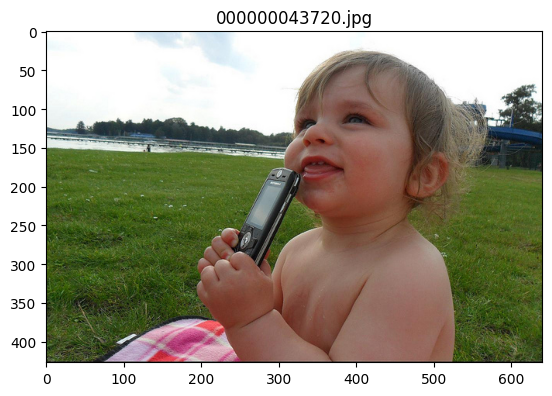

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_filename = '000000043720.jpg'  # Replace with the actual filename of the image you want to see

image_path = os.path.join(image_dir, image_filename)

try:
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(image_filename)
    plt.show()
except FileNotFoundError:
    print(f"Error: Image file '{image_path}' not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")